# Train a `bioLORD` model with `developing human immune across tissue` (focusing on B-cells)

The data was generated by Suo et al.[[1]](https://www.science.org/doi/full/10.1126/science.abo0510) and downloaded from [Lymphoid cells](https://cellgeni.cog.sanger.ac.uk/developmentcellatlas/fetal-immune/PAN.A01.v01.raw_count.20210429.LYMPHOID.embedding.h5ad). <br>
The complete dataset contains a cross-tissue single-cell atlas of developing human immune cells across prenatal hematopoietic, lymphoid, and nonlymphoid peripheral organs. This includes over 900,000 cells from which we identified over 100 cell states.

[[1] Suo, Chenqu, Emma Dann, Issac Goh, Laura Jardine, Vitalii Kleshchevnikov, Jong-Eun Park, Rachel A. Botting et al. "Mapping the developing human immune system across organs." Science (2022): eabo0510.](https://www.science.org/doi/full/10.1126/science.abo0510)


In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
sys.path.append("/cs/usr/bar246802/bar246802/SandBox2023/biolord_immune_bcells/utils") # add utils
sys.path.append("/cs/usr/bar246802/bar246802/SandBox2023/biolord") # set path)
import biolord
import scanpy as sc
import anndata
import numpy as np
import pandas as pd
import torch
import umap.plot
import seaborn as sns
import itertools
import matplotlib.pyplot as plt
import matplotlib as mpl
import re
import random
import scipy
from bioinfokit import analys, visuz
import matplotlib.patches as mpatches
from cluster_analysis import *
from formatters import *

[rank: 0] Global seed set to 0


In [3]:
%matplotlib inline

In [4]:
print(f"scipy version: {scipy.__version__}")
print(f"PyTorch version: {torch.__version__}")
# Set the device      
device = "gpu" if torch.backends.cuda.is_built() else "cpu"
print(f"Using device: {device}")

scipy version: 1.10.0
PyTorch version: 1.11.0
Using device: gpu


In [5]:
from tqdm import tqdm
tqdm(disable=True, total=0)  # initialise internal lock

In [6]:
import mplscience
mplscience.set_style()

plt.rcParams['legend.scatterpoints'] = 1

## Set parameters

In [7]:
DATA_DIR = "../data/"
SAVE_DIR = "../output/"
FIG_DIR = "../figures/"

## Import processed data

In [8]:
adata = sc.read(DATA_DIR + "biolord_immune_bcells_bm.h5ad")

In [9]:
adata.obs["split"].value_counts()

train    57436
test      6382
ood        160
Name: split, dtype: int64

## Train the model

In [10]:
# reconstruction_penalty
N_LATENT_ATTRIBUTE_CATEGORICAL = 4
module_params = {
    "autoencoder_width": 128,
    "autoencoder_depth": 2,
    "attribute_nn_width": 256,
    "attribute_nn_depth": 2,
    "n_latent_attribute_categorical": N_LATENT_ATTRIBUTE_CATEGORICAL,
    "loss_ae": "gauss",
    "loss_ordered_attribute": "gauss",
    "reconstruction_penalty": 1e2,
    "unknown_attribute_penalty": 1e1,
    "unknown_attribute_noise_param": 1e-1,
    "attribute_dropout_rate": 0.1,
    "use_batch_norm": False,
    "use_layer_norm": False,
    "seed": 42,
}


trainer_params = {
    "n_epochs_warmup": 0,
    "autoencoder_lr": 1e-4,
    "autoencoder_wd": 1e-4,
    "attribute_nn_lr": 1e-2,
    "attribute_nn_wd": 4e-8,
    "step_size_lr": 45,
    "cosine_scheduler": True,
    "scheduler_final_lr": 1e-5,
}

biolord.Biolord.setup_anndata(
    adata,
    categorical_attributes_keys=["celltype", "organ", "age"],
    retrieval_attribute_key="sex",
)

model = biolord.Biolord(
    adata=adata,
    n_latent=32,
    model_name="immune_bcells",
    module_params=module_params,
    train_classifiers=False,
    split_key="split",
)

[rank: 0] Global seed set to 42


In [11]:
model.train(max_epochs=1000,
            batch_size=512,
            plan_kwargs=trainer_params,
            early_stopping=True,
            early_stopping_patience=20,            
            check_val_every_n_epoch=10,
            num_workers=1)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/cs/labs/mornitzan/bar246802/SandBox2023/bioLordVenv/lib/python3.9/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:612: UserWarning: Checkpoint directory biolord_log/immune_bcells_Biolord/lightning_logs/version_1/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Epoch 112/1000:  11%|█         | 112/1000 [07:56<1:02:59,  4.26s/it, v_num=1, val_generative_mean_accuracy=0.454, val_generative_var_accuracy=0.172, val_biolord_metric=0.313, val_reconstruction_loss=313, val_unknown_attribute_penalty_loss=3.19, generative_mean_accuracy=0, generative_var_accuracy=0, biolord_metric=0, reconstruction_loss=31, unknown_attribute_penalty_loss=25.4]  
Monitored metric val_biolord_metric did not improve in the last 20 records. Best score: 0.355. Signaling Trainer to stop.


## Evaluate the trained model

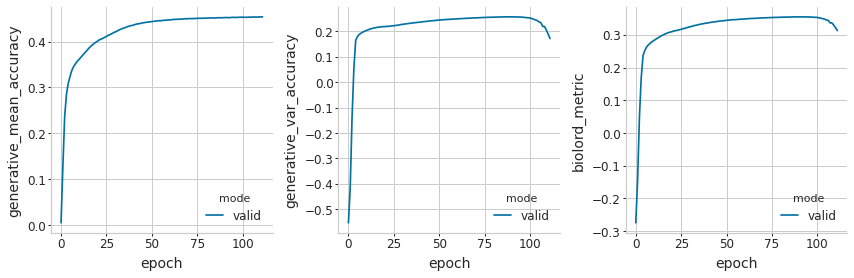

In [12]:
size = N_LATENT_ATTRIBUTE_CATEGORICAL
vals = [
    "generative_mean_accuracy", "generative_var_accuracy", "biolord_metric"
]
fig, axs = plt.subplots(nrows=1,
                        ncols=len(vals),
                        figsize=(size * len(vals), size))

model.epoch_history = pd.DataFrame().from_dict(
    model.training_plan.epoch_history)
for i, val in enumerate(vals):
    sns.lineplot(
        x="epoch",
        y=val,
        hue="mode",
        data=model.epoch_history[model.epoch_history["mode"] == "valid"],
        ax=axs[i],
    )

plt.tight_layout()
plt.show()

## Save the model

In [ ]:
model.save(SAVE_DIR + "trained_model_16_5_23")

## Load saved model

In [13]:
model = biolord.Biolord.load(dir_path=SAVE_DIR + "trained_model_16_5_23", adata=adata, use_gpu=False)

INFO     File ../output/trained_model_16_5_23/model.pt already downloaded                                          


[rank: 0] Global seed set to 42


## Generate Some statistics of our data

In [14]:
df_organ_counts = {}
for organ in set(adata.obs['organ']):
    adata_organ = adata.obs[adata.obs['organ'] == organ]
    organ_celltyps = list(set(adata_organ['celltype']))
    organ_ages = list(set(adata_organ['age']))
    df_organ_counts[organ] = {
        "organ": organ,
        "n_smaples": len(adata_organ),
       "celltypes": organ_celltyps,
        "n_celltypes": len(organ_celltyps),
        "ages": organ_ages,
        "n_ages": len(organ_ages)
    }
    
df_organ_counts = pd.DataFrame().from_dict(df_organ_counts).T
df_organ_counts.to_csv(SAVE_DIR + "df_organ_counts.csv", index=False)
df_organ_counts

organ n_smaples                                          celltypes  \
BM     BM     25764  [MATURE_B, LARGE_PRE_B, PRE_PRO_B, SMALL_PRE_B...   
SP     SP     22418  [LATE_PRO_B, LARGE_PRE_B, MATURE_B, PRE_PRO_B,...   
TH     TH       827  [LATE_PRO_B, LARGE_PRE_B, MATURE_B, PRE_PRO_B,...   
YS     YS        53                 [PRE_PRO_B, MATURE_B, LARGE_PRE_B]   
SK     SK      2284  [LATE_PRO_B, LARGE_PRE_B, MATURE_B, PRE_PRO_B,...   
LI     LI     11049  [LATE_PRO_B, LARGE_PRE_B, MATURE_B, PRE_PRO_B,...   
MLN   MLN       651  [LATE_PRO_B, MATURE_B, LARGE_PRE_B, PRE_PRO_B,...   
KI     KI       497  [LATE_PRO_B, MATURE_B, LARGE_PRE_B, PRE_PRO_B,...   
GU     GU       435  [LARGE_PRE_B, MATURE_B, PRE_PRO_B, SMALL_PRE_B...   

    n_celltypes                           ages n_ages  
BM           10           [12, 14, 15, 16, 17]      5  
SP           10    [9, 11, 12, 14, 15, 16, 17]      7  
TH           10        [7, 11, 12, 14, 16, 17]      6  
YS            3                            [7]      1  
SK           10  [7, 8, 9, 11, 12, 14, 15, 16]      8  
LI           10  [7, 8, 9, 11, 12, 14, 16, 17]      8  
MLN          10                       [16, 17]      2  
KI            9                    [16, 12, 7]      3  
GU            9                   [16, 17, 15]      3

In [15]:
df_celltype_counts = {}
for celltype in set(adata.obs['celltype']):
    adata_celltype = adata.obs[adata.obs['celltype'] == celltype]
    celltype_organs = list(set(adata_celltype['organ']))
    celltype_ages = list(set(adata_celltype['age']))
    df_celltype_counts[celltype] = {
        "celltype": celltype,
        "n_smaples": len(adata_celltype),
       "organs": celltype_organs,
        "n_organs": len(celltype_organs),
        "ages": celltype_ages,
        "n_ages": len(celltype_ages)
    }
    
df_celltype_counts = pd.DataFrame().from_dict(df_celltype_counts).T
df_celltype_counts.to_csv(SAVE_DIR + "df_celltype_counts.csv", index=False)
df_celltype_counts

celltype n_smaples                                 organs  \
LATE_PRO_B    LATE_PRO_B      6339      [BM, SP, TH, SK, LI, MLN, KI, GU]   
LARGE_PRE_B  LARGE_PRE_B     10464  [BM, SP, TH, YS, SK, LI, MLN, KI, GU]   
MATURE_B        MATURE_B     17487  [BM, SP, TH, YS, SK, LI, MLN, KI, GU]   
PRE_PRO_B      PRE_PRO_B      3014  [BM, SP, TH, YS, SK, LI, MLN, KI, GU]   
SMALL_PRE_B  SMALL_PRE_B      8262      [BM, SP, TH, SK, LI, MLN, KI, GU]   
PRO_B              PRO_B      8111      [BM, SP, TH, SK, LI, MLN, KI, GU]   
PLASMA_B        PLASMA_B        60              [BM, SP, TH, SK, LI, MLN]   
B1                    B1      5649      [BM, SP, TH, SK, LI, MLN, KI, GU]   
IMMATURE_B    IMMATURE_B      2685      [BM, SP, TH, SK, LI, MLN, KI, GU]   
CYCLING_B      CYCLING_B      1907      [BM, SP, TH, SK, LI, MLN, KI, GU]   

            n_organs                               ages n_ages  
LATE_PRO_B         8  [7, 8, 9, 11, 12, 14, 15, 16, 17]      9  
LARGE_PRE_B        9  [7, 8, 9, 11, 12, 14, 15, 16, 17]      9  
MATURE_B           9  [7, 8, 9, 11, 12, 14, 15, 16, 17]      9  
PRE_PRO_B          9  [7, 8, 9, 11, 12, 14, 15, 16, 17]      9  
SMALL_PRE_B        8  [7, 8, 9, 11, 12, 14, 15, 16, 17]      9  
PRO_B              8  [7, 8, 9, 11, 12, 14, 15, 16, 17]      9  
PLASMA_B           6               [12, 14, 15, 16, 17]      5  
B1                 8     [8, 9, 11, 12, 14, 15, 16, 17]      8  
IMMATURE_B         8  [7, 8, 9, 11, 12, 14, 15, 16, 17]      9  
CYCLING_B          8        [9, 11, 12, 14, 15, 16, 17]      7

## Cluster embeddings and UMAP of latent space

In [16]:
# fetch the attributes dataframe
transf_embeddings_attributes, df, df_attributes_map, transf_embeddings_attributes_ind = get_transf_embeddings_attributes(
    model)
# format the labels to full name
df["celltype_name"] = switch_to_celltype_fullname(df["celltype"])
df["organ_name"] = switch_to_organ_fullname(df["organ"])

df_attributes_map =    attribute          key  value
0   celltype           B1      0
1   celltype    CYCLING_B      1
2   celltype   IMMATURE_B      2
3   celltype  LARGE_PRE_B      3
4   celltype   LATE_PRO_B      4
5   celltype     MATURE_B      5
6   celltype     PLASMA_B      6
7   celltype    PRE_PRO_B      7
8   celltype        PRO_B      8
9   celltype  SMALL_PRE_B      9
10     organ           BM      0
11     organ           GU      1
12     organ           KI      2
13     organ           LI      3
14     organ          MLN      4
15     organ           SK      5
16     organ           SP      6
17     organ           TH      7
18     organ           YS      8


In [17]:
# Run PCA to for UMAP
pca = sc.tl.pca(transf_embeddings_attributes)
# Run UMAP
mapper_latent = umap.UMAP().fit_transform(transf_embeddings_attributes)
# Create Data Frame for UMAP figure
df_umap = pd.DataFrame(mapper_latent, columns=["umap1", "umap2"])
df = df.assign(**df_umap)
for i in range(pca.shape[1]):
    df[f"pc{i+1}"] = pca[:, i]

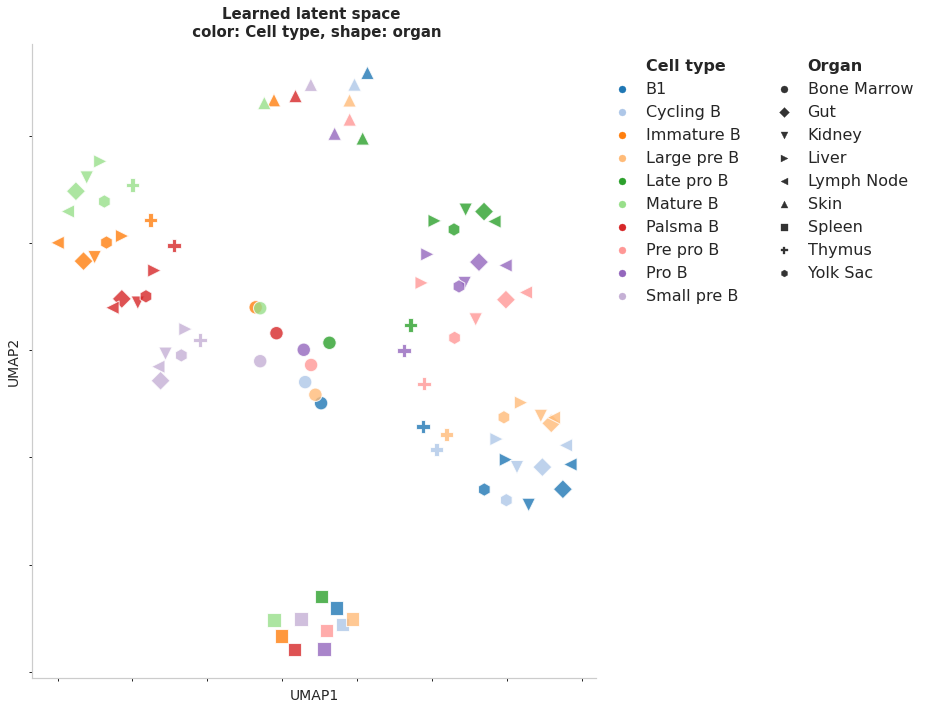

In [18]:
# create UMAP of latent space
fig, axs = plt.subplots(1, 1, figsize=(13, 10))

color_palette = sns.color_palette("tab20", n_colors=10)
# bind each dot shape to the organ and it's color to the celltype
sns.scatterplot(data=df,
                x="umap1",
                y="umap2",
                hue="celltype_name",
                style="organ_name",
                ax=axs,
                alpha=.8,
                s=180,
                markers = ['o', 'D', 'v', '>', '<', '^', 's', 'P', 'h'],
                palette=color_palette
#                 palette="deep"
               )

axs.set_title("Learned latent space \n color: Cell type, shape: organ", fontweight='bold')
axs.set(xticklabels=[], yticklabels=[])
axs.set_xlabel("UMAP1")
axs.set_ylabel("UMAP2")
axs.grid(False)
legend = axs.legend(loc="upper left", bbox_to_anchor=(1, 1), ncols=2, prop={'size': 16})
for text in legend.get_texts():
    if text.get_text() == 'celltype_name' or text.get_text() == 'organ_name':
        if text.get_text() == 'celltype_name':
            text.set_text("Cell type")
        else:
            text.set_text("Organ")
        text.set_fontsize(16)
        text.set_fontweight('bold')
plt.tight_layout()
plt.savefig(FIG_DIR + f"cell_type_umap.png",
            dpi=300,
            bbox_inches="tight",
            transparent=True)
plt.show()

## Expression predictions of cells shifts

In [19]:
def get_adata_preds(source_organ, source_celltype, source_age):
    if source_organ is not None:
        idx_source = np.where(
            (adata.obs["split"] == "train") & 
            (adata.obs["organ"] == source_organ)
        )[0]
        adata_source = adata[idx_source].copy()
    if source_celltype is not None:
        idx_source = np.where(
            (adata_source.obs["split"] == "train") & 
            (adata_source.obs["celltype"] == source_celltype)
        )[0]
        adata_source = adata_source[idx_source].copy()
    if source_age is not None:
        idx_source = np.where(
            (adata_source.obs["split"] == "train") & 
            (adata_source.obs["age"] == source_age)
        )[0]
        adata_source = adata_source[idx_source].copy()
    print(f"size of adata_source = {adata_source.shape}")
    adata_preds = model.compute_prediction_adata(
        adata,
        adata_source,
        target_attributes=["organ"],
        add_attributes=["celltype", "age", "sex"],
    )
    
    return adata_source, adata_preds

In [20]:
def umap_preds():
    sc.pp.pca(adata_preds)
    sc.pp.neighbors(adata_preds)
    sc.tl.umap(adata_preds)
    size = 6
    fig, axs = plt.subplots(1, 2, figsize=(2 * (size + 1), size))

    for i, c in enumerate(["celltype", "organ"]):
        sc.pl.umap(adata_preds, color=[c], ax=axs[i], show=False)
        axs[i].set_xlabel("UMAP1")
        axs[i].set_ylabel("UMAP2")
        axs[i].legend(loc="upper left", bbox_to_anchor=(1, 1), ncols=2)
        axs[i].set_axis_off()


    plt.tight_layout()
    plt.savefig(FIG_DIR + f"{SOURCE_ORGAN}_to_sp_umap.png",
                dpi=300,
                bbox_inches="tight",
                transparent=True)
    plt.show()

## Calculate genes significant score

In [21]:
def get_data_from_preds(target):
    if target['organ'] is not None:
        idx_source = np.where(
            (adata_preds.obs["organ"] == target['organ'])
        )[0]
        adata_target = adata_preds[idx_source].copy()
    if target['celltype'] is not None:
        idx_source = np.where(
            (adata_target.obs["celltype"] == target['celltype'])
        )[0]
        adata_target = adata_target[idx_source].copy()
    if target['age'] is not None:
        idx_source = np.where(
            (adata_target.obs["age"] == target['age'])
        )[0]
        adata_target = adata_target[idx_source].copy()
    
    return adata_target

In [22]:
def get_significant_genes(df_pvalue):
    df_significant = df_pvalue[df_pvalue['pvalue'] < 0.05]
    print(df_significant.head(10))
    print(f"with alpha = 0.05, size of df_significant = {len(df_significant)}")
    return df_significant

In [23]:
def calc_genes_scores(source, target):
    from scipy.stats import ttest_rel    
    scores_genes_ttest = {}
    a = get_data_from_preds(source)
    b = get_data_from_preds(target)
    for gene in adata_source.var_names:
        a_gene = a[[True]*len(a), gene]
        b_gene = b[[True]*len(b), gene]     
        res = ttest_rel(
            a=a_gene.X,
            b=b_gene.X,
            alternative='two-sided'
        )
        x_delta = a_gene.X - b_gene.X
        x_delta_mean = np.array(x_delta).mean()
        scores_genes_ttest[gene] = {
            "gene": gene,
            "geneID": adata.var['GeneID'][gene],
            "statistic": res.statistic[0],
            "pvalue": res.pvalue[0],
            "x_delta_mean": x_delta_mean
        }
    df_pvalue = pd.DataFrame.from_dict(scores_genes_ttest).T
    df_pvalue = df_pvalue.sort_values(by=['pvalue'], ascending=True)
    print(f"size of df_pvalue = {len(df_pvalue)}")
    print(f"Moving cells from {source} to {target} returns the following significant_genes:")
    df_significant = get_significant_genes(df_pvalue)
    
    
    # gene expression levels
    print("\n************ Real genes  *****************\n")
    genes_expression = calc_genes_diff_expression(source, target, genes_in_list, title="Genes of interest")
    print(f"the mean expression level is: {genes_expression['mean'].mean()}")
    print(genes_expression)
    print("\n************** Random genes ***************\n")
    random_genes = random.sample(list(adata_source.var_names), 50)
    random_genes_expression = calc_genes_diff_expression(source, target, random_genes, title="Random genes")
    print(f"the mean expression level is: {random_genes_expression['mean'].mean()}")
    print(random_genes_expression)
    file_name = SAVE_DIR + f"{source['organ'].lower()}_to_{target['organ'].lower()}_random_genes_expression.csv"
    random_genes_expression.to_csv(file_name, index=False)
    
    return df_significant.sort_values(by=['statistic', "pvalue"], ascending=True), genes_expression

In [24]:
def calc_genes_diff_expression(source, target, genes = [], title=""):
    genes_x_delta_mean = {}
    source_data = adata_preds[((adata_preds.obs["organ"] == source['organ']) & (adata_preds.obs["celltype"] == source['celltype']))]
    target_data = adata_preds[((adata_preds.obs["organ"] == target['organ']) & (adata_preds.obs["celltype"] == target['celltype']))]
    print(f"mean expression levels for {len(genes)} genes are calculated from {len(target_data)} samples")
    df_genes = {}
    for gene in genes:
        a=adata_preds[((adata_preds.obs["organ"] == source['organ']) & (adata_preds.obs["celltype"] == source['celltype'])), gene]
        b=adata_preds[((adata_preds.obs["organ"] == target['organ']) & (adata_preds.obs["celltype"] == target['celltype'])), gene]
        
        x_delta = a.X - b.X
        x_delta_mean = np.array(x_delta).mean()
        df_genes[gene] = {
            "gene": adata.var['GeneID'][gene],
            "mean": x_delta_mean
        }
    df_genes = pd.DataFrame.from_dict(df_genes).T
    df_genes = df_genes.sort_values(by=['mean'], ascending=False)
    return df_genes

In [25]:
def fomart_organ_key_to_fullname(key):
    organ_dic = {
        "BM": "Bone Marrow",
        "GU": "Gut",
        "KI": "Kidney",
        "LI": "Liver",
        "MLN": "Lymph Node",
        "SK": "Skin",
        "SP": "Spleen",
        "TH": "Thymus",
        "YS": "Yolk Sac",
    }
    return organ_dic[key]

In [26]:
def fomart_celltype_key_to_fullname(key):
    celltype_dic = {
        "B1": "B1",
        "CYCLING_B": "Cycling B",
        "IMMATURE_B": "Immature B",
        "LARGE_PRE_B": "Large Pre B",
        "LATE_PRO_B": "Late Pro B",
        "MATURE_B": "Mature B",
        "PLASMA_B": "Palsma B",
        "PRE_PRO_B": "Pre Pro B",
        "PRO_B": "Pro B",
        "SMALL_PRE_B": "Small Pre B",
    }
    return celltype_dic[key]

In [29]:
# Creating a list of genes of interest, most of the list is taken from Figure 3B from the Suo et al 2022
genes_fig3b_tnf = [
    "ATF3",
    "BIRC3",
    "CD44",
    "CD83",
    "CEBPD",
    "CXCL3",
    "DNAJB4",
    "DUSP1",
    "DUSP4",
    "FOS",
    "FOSB",
    
    "ICAM1",
    "IER5",
    
    "JUN", # FROM https://www.nature.com/articles/s42003-023-04454-5
    "JUNB",
    
    "KDM6B",
    "KLF2",
    "KLF4",
    "KLF6",
    "NFKB1",
    "NFKBIA",
    "REL",
    "RHOB",
    "SGK1"
]

genes_fig3b_inflam = [
    "CCR7",
    "CD27"
    "CD48",
    "CD70",
    "CXCR5",
    "EMP3",    
    "RGS16",
]

genes_fig3b_immune_func = [
    "CCL4L2",
    "CD200R1",
    "CLEC2B",
    "GZMB",
    "IL10",
    "ITGA4",
    "SLA2",
    "TIGIT"
]

genes_fig3b = genes_fig3b_tnf + genes_fig3b_inflam + genes_fig3b_immune_func
num_of_random_genes = 10
random_genes = random.sample([x for x in list(adata.var_names) if x not in genes_fig3b], num_of_random_genes)

genes_fig3b += random_genes

genes_colors = {}
for gene in genes_fig3b:
    if gene in genes_fig3b_tnf:
        genes_colors[gene] = "green"
    elif gene in genes_fig3b_inflam:
        genes_colors[gene] = "orange"
    elif gene in genes_fig3b_immune_func:
        genes_colors[gene] = "purple"
    else:
        genes_colors[gene] = "gray"

## Predict genes expression profile when shifting cells from the Yolk sac to other organs - This simulating the natural migrations of cells in the developing human body

In [30]:
SOURCE_ORGAN = "YS"
SOURCE_CELLTYPE = "PRE_PRO_B"
SOURCE_AGE = 7
adata_source, adata_preds = get_adata_preds(source_organ=SOURCE_ORGAN, source_celltype=SOURCE_CELLTYPE, source_age=SOURCE_AGE)

size of adata_source = (40, 4204)
INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        


0it [00:00, ?it/s]

INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        


/cs/labs/mornitzan/bar246802/SandBox2023/bioLordVenv/lib/python3.9/site-packages/scvi/data/_utils.py:175: UserWarning: Category 6 in adata.obs['_scvi_celltype'] has fewer than 3 cells. Models may not train properly.
  warnings.warn(
1it [00:00,  2.01it/s]

INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        
INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        
INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        


4it [00:00,  6.12it/s]

INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        
INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        


/cs/labs/mornitzan/bar246802/SandBox2023/bioLordVenv/lib/python3.9/site-packages/scvi/data/_utils.py:175: UserWarning: Category 6 in adata.obs['_scvi_celltype'] has fewer than 3 cells. Models may not train properly.
  warnings.warn(
/cs/labs/mornitzan/bar246802/SandBox2023/bioLordVenv/lib/python3.9/site-packages/scvi/data/_utils.py:175: UserWarning: Category 6 in adata.obs['_scvi_celltype'] has fewer than 3 cells. Models may not train properly.
  warnings.warn(


INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        


7it [00:01,  6.12it/s]

INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        
INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        


9it [00:01,  6.97it/s]


/cs/labs/mornitzan/bar246802/SandBox2023/bioLordVenv/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/cs/labs/mornitzan/bar246802/SandBox2023/bioLordVenv/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


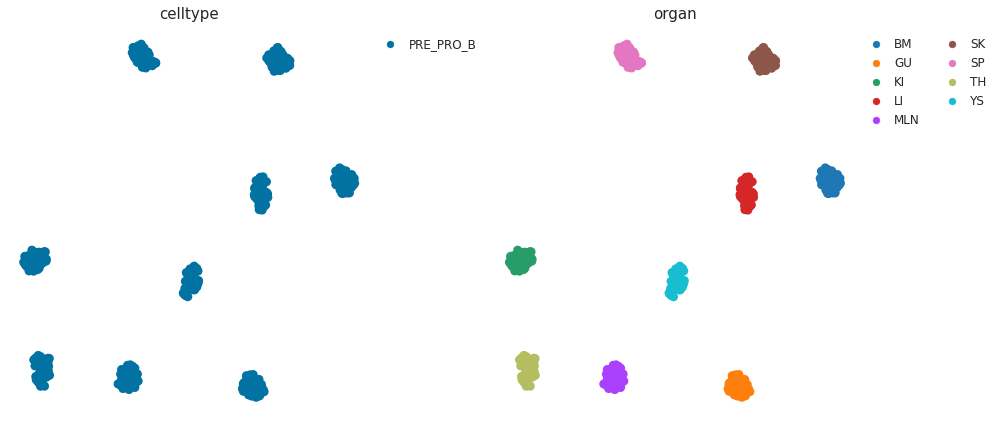

In [31]:
umap_preds()

In [32]:
# Create CSV file output to be used later in the GSEA, 
# for each gene we calculate a t-score stating how much the mean expression of this gene was changed
# due to the shift btw organs
# Shift from Yolk sac to Spleen
genes_in_list = list(set([gene for gene in genes_fig3b if gene in adata_source.var_names]))
source = {"organ": SOURCE_ORGAN, "celltype": SOURCE_CELLTYPE, "age": SOURCE_AGE}
target = {"organ": "SP", "celltype": SOURCE_CELLTYPE, "age": SOURCE_AGE}
df_pvalue_ys_to_sp, genes_expression_ys_to_sp = calc_genes_scores(source, target)
df_pvalue_ys_to_sp.to_csv(SAVE_DIR + "ys_to_sp_ttest.csv", index=True)
genes_expression_ys_to_sp.to_csv(SAVE_DIR + "ys_to_sp_genes_expression.csv", index=True)

size of df_pvalue = 4204
Moving cells from {'organ': 'YS', 'celltype': 'PRE_PRO_B', 'age': 7} to {'organ': 'SP', 'celltype': 'PRE_PRO_B', 'age': 7} returns the following significant_genes:
                  gene           geneID    statistic pvalue x_delta_mean
CITED2          CITED2  ENSG00000164442 -1280.151729    0.0    -0.571591
KREMEN2        KREMEN2  ENSG00000131650  1009.328491    0.0     0.264735
HOXB2            HOXB2  ENSG00000173917  -996.511806    0.0    -0.282877
AC108134.2  AC108134.2  ENSG00000261889  -970.194138    0.0    -0.581536
HLA-DQA2      HLA-DQA2  ENSG00000237541   962.892966    0.0     0.539701
SLC5A3          SLC5A3  ENSG00000198743  -947.716532    0.0    -0.464456
IER2              IER2  ENSG00000160888  -921.647454    0.0    -0.491215
DBNDD1          DBNDD1  ENSG00000003249   918.435514    0.0     0.466013
CD69              CD69  ENSG00000110848  -861.945678    0.0    -0.615761
DUSP1            DUSP1  ENSG00000120129  -858.052684    0.0    -0.481103
with alp

In [33]:
# Shift from Yolk sac to Skin
source = {"organ": SOURCE_ORGAN, "celltype": SOURCE_CELLTYPE, "age": SOURCE_AGE}
target = {"organ": "SK", "celltype": SOURCE_CELLTYPE, "age": SOURCE_AGE}
df_pvalue_ys_to_sk, genes_expression_ys_to_sk = calc_genes_scores(source, target)
df_pvalue_ys_to_sk.to_csv(SAVE_DIR + "ys_to_sk_ttest.csv", index=True)
genes_expression_ys_to_sk.to_csv(SAVE_DIR + "ys_to_sk_genes_expression.csv", index=False)

size of df_pvalue = 4204
Moving cells from {'organ': 'YS', 'celltype': 'PRE_PRO_B', 'age': 7} to {'organ': 'SK', 'celltype': 'PRE_PRO_B', 'age': 7} returns the following significant_genes:
                  gene           geneID    statistic pvalue x_delta_mean
EEF1G            EEF1G  ENSG00000254772 -1055.012232    0.0    -0.750726
RNASE1          RNASE1  ENSG00000129538  -974.937333    0.0     -0.48967
HSPA1B          HSPA1B  ENSG00000204388   917.919091    0.0     0.838734
DLX2              DLX2  ENSG00000115844   804.321634    0.0     0.178957
COL1A2          COL1A2  ENSG00000164692  -798.340565    0.0    -0.365069
RHOB              RHOB  ENSG00000143878   791.308096    0.0     0.595977
AC011676.1  AC011676.1  ENSG00000253307    786.71268    0.0     0.034478
C1QTNF4        C1QTNF4  ENSG00000172247  -782.424262    0.0    -0.771141
DBNDD1          DBNDD1  ENSG00000003249  -758.001444    0.0    -0.565637
IGFBP4          IGFBP4  ENSG00000141753   752.469382    0.0     0.354808
with alp

In [34]:
# Shift from Yolk sac to Liver
source = {"organ": SOURCE_ORGAN, "celltype": SOURCE_CELLTYPE, "age": SOURCE_AGE}
target = {"organ": "LI", "celltype": SOURCE_CELLTYPE, "age": SOURCE_AGE}
df_pvalue_ys_to_li, genes_expression_ys_to_li = calc_genes_scores(source, target)
df_pvalue_ys_to_li.to_csv(SAVE_DIR + "ys_to_li_ttest.csv", index=True)
genes_expression_ys_to_li.to_csv(SAVE_DIR + "ys_to_li_genes_expression.csv", index=False)

size of df_pvalue = 4204
Moving cells from {'organ': 'YS', 'celltype': 'PRE_PRO_B', 'age': 7} to {'organ': 'LI', 'celltype': 'PRE_PRO_B', 'age': 7} returns the following significant_genes:
            gene           geneID   statistic pvalue x_delta_mean
TAGAP      TAGAP  ENSG00000164691  853.884212    0.0     0.340038
FOS          FOS  ENSG00000170345  796.671124    0.0     0.354513
CCL5        CCL5  ENSG00000271503  725.180658    0.0     0.307388
TSC22D3  TSC22D3  ENSG00000157514  720.882582    0.0     0.362343
LMNA        LMNA  ENSG00000160789  671.061446    0.0     0.486659
FOSB        FOSB  ENSG00000125740  619.345888    0.0     0.364372
DUSP4      DUSP4  ENSG00000120875  610.803715    0.0     0.568752
RPL13A    RPL13A  ENSG00000142541 -610.227959    0.0    -0.307348
INSIG1    INSIG1  ENSG00000186480  587.638526    0.0     0.246742
KLF6        KLF6  ENSG00000067082  586.228249    0.0     0.449072
with alpha = 0.05, size of df_significant = 4159

************ Real genes  **********

## Repeating the process this time the source organ is the Liver

In [35]:
SOURCE_ORGAN = "LI"
SOURCE_CELLTYPE = "PRE_PRO_B"
SOURCE_AGE = 7
adata_source, adata_preds = get_adata_preds(source_organ=SOURCE_ORGAN, source_celltype=SOURCE_CELLTYPE, source_age=SOURCE_AGE)

size of adata_source = (500, 4204)
INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        


0it [00:00, ?it/s]

INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        


/cs/labs/mornitzan/bar246802/SandBox2023/bioLordVenv/lib/python3.9/site-packages/scvi/data/_utils.py:175: UserWarning: Category 6 in adata.obs['_scvi_celltype'] has fewer than 3 cells. Models may not train properly.
  warnings.warn(
1it [00:00,  2.26it/s]

INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        
INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        
INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        


4it [00:00,  6.69it/s]

INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        
INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        


/cs/labs/mornitzan/bar246802/SandBox2023/bioLordVenv/lib/python3.9/site-packages/scvi/data/_utils.py:175: UserWarning: Category 6 in adata.obs['_scvi_celltype'] has fewer than 3 cells. Models may not train properly.
  warnings.warn(
/cs/labs/mornitzan/bar246802/SandBox2023/bioLordVenv/lib/python3.9/site-packages/scvi/data/_utils.py:175: UserWarning: Category 6 in adata.obs['_scvi_celltype'] has fewer than 3 cells. Models may not train properly.
  warnings.warn(


INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        


7it [00:01,  6.56it/s]

INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        
INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        


9it [00:01,  7.54it/s]


/cs/labs/mornitzan/bar246802/SandBox2023/bioLordVenv/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/cs/labs/mornitzan/bar246802/SandBox2023/bioLordVenv/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


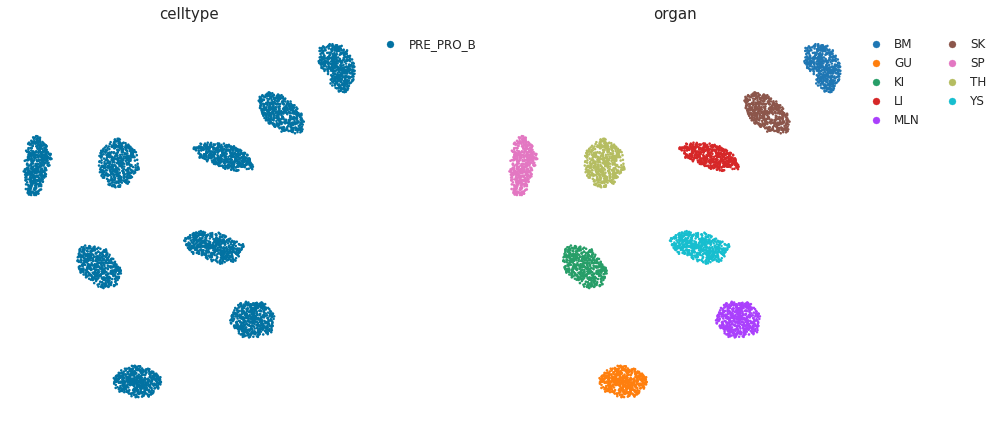

In [36]:
umap_preds()

In [37]:
# Shift from Liver to Spleen
genes_in_list = list(set([gene for gene in genes_fig3b if gene in adata_source.var_names]))
source = {"organ": SOURCE_ORGAN, "celltype": SOURCE_CELLTYPE, "age": SOURCE_AGE}
target = {"organ": "SP", "celltype": SOURCE_CELLTYPE, "age": SOURCE_AGE}
df_pvalue_li_to_sp, genes_expression_li_to_sp = calc_genes_scores(source, target)
df_pvalue_li_to_sp.to_csv(SAVE_DIR + "li_to_sp_ttest.csv", index=True)
genes_expression_li_to_sp.to_csv(SAVE_DIR + "li_to_sp_genes_expression.csv", index=True)

size of df_pvalue = 4204
Moving cells from {'organ': 'LI', 'celltype': 'PRE_PRO_B', 'age': 7} to {'organ': 'SP', 'celltype': 'PRE_PRO_B', 'age': 7} returns the following significant_genes:
                  gene           geneID   statistic pvalue x_delta_mean
SEMA3F          SEMA3F  ENSG00000001617  198.240963    0.0      0.00755
TMEM253        TMEM253  ENSG00000232070 -571.112883    0.0    -0.008669
AC012313.1  AC012313.1  ENSG00000232098 -690.719446    0.0    -0.058299
LINC01873    LINC01873  ENSG00000232164  352.176393    0.0     0.014721
AL353613.1  AL353613.1  ENSG00000232211 -360.005855    0.0    -0.004915
IGHV3-43      IGHV3-43  ENSG00000232216 -192.581503    0.0    -0.024374
AC239803.1  AC239803.1  ENSG00000232265 -850.319818    0.0    -0.015383
OR52I1          OR52I1  ENSG00000232268 -988.972938    0.0    -0.048151
GNG12-AS1    GNG12-AS1  ENSG00000232284  116.958484    0.0     0.003195
AL390728.5  AL390728.5  ENSG00000232347  966.501931    0.0     0.149711
with alpha = 0.05, 

In [38]:
# Shift from Liver to Skin
genes_in_list = list(set([gene for gene in genes_fig3b if gene in adata_source.var_names]))
source = {"organ": SOURCE_ORGAN, "celltype": SOURCE_CELLTYPE, "age": SOURCE_AGE}
target = {"organ": "SK", "celltype": SOURCE_CELLTYPE, "age": SOURCE_AGE}
df_pvalue_li_to_sk, genes_expression_li_to_sk = calc_genes_scores(source, target)
df_pvalue_li_to_sk.to_csv(SAVE_DIR + "li_to_sk_ttest.csv", index=True)
genes_expression_li_to_sk.to_csv(SAVE_DIR + "li_to_sk_genes_expression.csv", index=True)

size of df_pvalue = 4204
Moving cells from {'organ': 'LI', 'celltype': 'PRE_PRO_B', 'age': 7} to {'organ': 'SK', 'celltype': 'PRE_PRO_B', 'age': 7} returns the following significant_genes:
                  gene           geneID   statistic pvalue x_delta_mean
SEMA3F          SEMA3F  ENSG00000001617 -276.197542    0.0    -0.007019
AP003774.3  AP003774.3  ENSG00000231680  493.252749    0.0     0.037818
LINC01273    LINC01273  ENSG00000231742  338.733756    0.0     0.003824
AC092652.1  AC092652.1  ENSG00000231758  379.432429    0.0     0.006528
AL355312.2  AL355312.2  ENSG00000231760 -760.640186    0.0    -0.035589
LINC01354    LINC01354  ENSG00000231768  360.796852    0.0     0.006788
LINC01819    LINC01819  ENSG00000231826  341.456132    0.0      0.01195
CYP21A2        CYP21A2  ENSG00000231852  636.485629    0.0     0.019702
AC093734.1  AC093734.1  ENSG00000231927  144.045122    0.0     0.006948
AL731567.1  AL731567.1  ENSG00000231964 -181.592224    0.0    -0.006654
with alpha = 0.05, 

In [39]:
# Shift from Liver to Bone Marrow 
genes_in_list = list(set([gene for gene in genes_fig3b if gene in adata_source.var_names]))
source = {"organ": SOURCE_ORGAN, "celltype": SOURCE_CELLTYPE, "age": SOURCE_AGE}
target = {"organ": "BM", "celltype": SOURCE_CELLTYPE, "age": SOURCE_AGE}
df_pvalue_li_to_bm, genes_expression_li_to_bm = calc_genes_scores(source, target)
df_pvalue_li_to_bm.to_csv(SAVE_DIR + "li_to_bm_ttest.csv", index=True)
genes_expression_li_to_bm.to_csv(SAVE_DIR + "li_to_bm_genes_expression.csv", index=True)

size of df_pvalue = 4204
Moving cells from {'organ': 'LI', 'celltype': 'PRE_PRO_B', 'age': 7} to {'organ': 'BM', 'celltype': 'PRE_PRO_B', 'age': 7} returns the following significant_genes:
                  gene           geneID    statistic pvalue x_delta_mean
SEMA3F          SEMA3F  ENSG00000001617   -228.83065    0.0    -0.005501
TMEM253        TMEM253  ENSG00000232070  -238.059382    0.0    -0.003016
AC012313.1  AC012313.1  ENSG00000232098  -171.224031    0.0    -0.010715
RAP2C-AS1    RAP2C-AS1  ENSG00000232160  -739.790463    0.0    -0.060655
LINC01873    LINC01873  ENSG00000232164  1194.179725    0.0     0.043338
LINC02181    LINC02181  ENSG00000232190   110.308351    0.0     0.006448
MTRNR2L4      MTRNR2L4  ENSG00000232196  -513.717558    0.0     -0.02289
AL353613.1  AL353613.1  ENSG00000232211  -142.848415    0.0    -0.002239
IGHV3-43      IGHV3-43  ENSG00000232216   643.226929    0.0     0.066053
AC008440.2  AC008440.2  ENSG00000232220   479.111049    0.0     0.013977
with alp

## And again for the Thymus

In [40]:
SOURCE_ORGAN = "TH"
SOURCE_CELLTYPE = "PRE_PRO_B"
SOURCE_AGE = 12
adata_source, adata_preds = get_adata_preds(source_organ=SOURCE_ORGAN, source_celltype=SOURCE_CELLTYPE, source_age=SOURCE_AGE)

size of adata_source = (23, 4204)
INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        


0it [00:00, ?it/s]

INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        


/cs/labs/mornitzan/bar246802/SandBox2023/bioLordVenv/lib/python3.9/site-packages/scvi/data/_utils.py:175: UserWarning: Category 6 in adata.obs['_scvi_celltype'] has fewer than 3 cells. Models may not train properly.
  warnings.warn(
1it [00:00,  2.25it/s]

INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        
INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        
INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        


4it [00:00,  6.70it/s]

INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        
INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        


/cs/labs/mornitzan/bar246802/SandBox2023/bioLordVenv/lib/python3.9/site-packages/scvi/data/_utils.py:175: UserWarning: Category 6 in adata.obs['_scvi_celltype'] has fewer than 3 cells. Models may not train properly.
  warnings.warn(
/cs/labs/mornitzan/bar246802/SandBox2023/bioLordVenv/lib/python3.9/site-packages/scvi/data/_utils.py:175: UserWarning: Category 6 in adata.obs['_scvi_celltype'] has fewer than 3 cells. Models may not train properly.
  warnings.warn(


INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        


7it [00:01,  6.53it/s]

INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        
INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        


9it [00:01,  7.51it/s]


/cs/labs/mornitzan/bar246802/SandBox2023/bioLordVenv/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/cs/labs/mornitzan/bar246802/SandBox2023/bioLordVenv/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


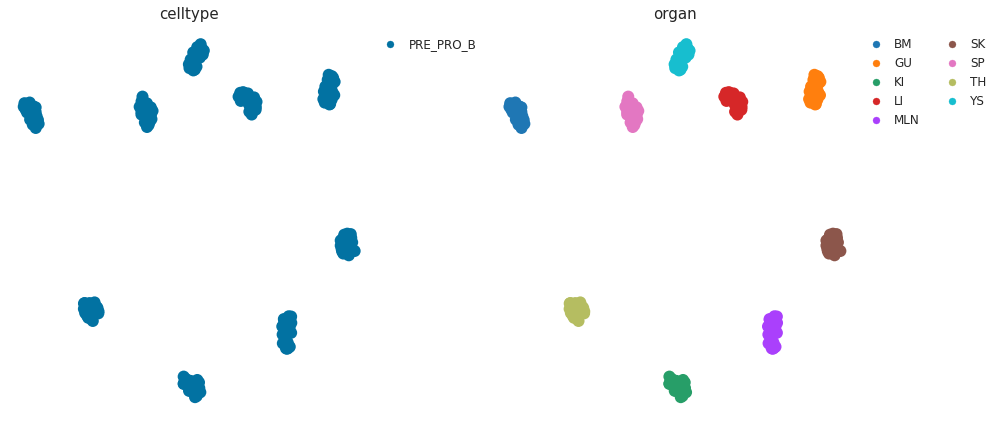

In [41]:
umap_preds()

In [42]:
# Shift from Thymus to Spleen
source = {"organ": SOURCE_ORGAN, "celltype": SOURCE_CELLTYPE, "age": SOURCE_AGE}
target = {"organ": "SP", "celltype": SOURCE_CELLTYPE, "age": SOURCE_AGE}
df_pvalue_th_sp, genes_expression_th_sp = calc_genes_scores(source, target)
df_pvalue_th_sp.to_csv(SAVE_DIR + "th_to_sp_ttest.csv", index=True)
genes_expression_th_sp.to_csv(SAVE_DIR + "th_to_sp_genes_expression.csv", index=False)

size of df_pvalue = 4204
Moving cells from {'organ': 'TH', 'celltype': 'PRE_PRO_B', 'age': 12} to {'organ': 'SP', 'celltype': 'PRE_PRO_B', 'age': 12} returns the following significant_genes:
                  gene           geneID    statistic pvalue x_delta_mean
PF4                PF4  ENSG00000163737 -1161.054532    0.0    -1.006513
FP671120.3  FP671120.3  ENSG00000280800  -938.549981    0.0    -0.503178
AC002454.1  AC002454.1  ENSG00000237819  -921.411774    0.0     -0.79889
PDGFRB          PDGFRB  ENSG00000113721  -804.901282    0.0    -0.832056
THBS1            THBS1  ENSG00000137801  -798.140737    0.0     -0.27633
PPBP              PPBP  ENSG00000163736  -785.428251    0.0    -0.658709
TNF                TNF  ENSG00000232810  -776.664353    0.0    -0.599811
FP671120.4  FP671120.4  ENSG00000281383  -771.836015    0.0    -0.473428
TLE4              TLE4  ENSG00000106829  -755.978546    0.0    -0.408951
HBG1              HBG1  ENSG00000213934  -741.380249    0.0    -1.106746
with a

In [43]:
# Shift from Liver to Lymph Nodes
source = {"organ": SOURCE_ORGAN, "celltype": SOURCE_CELLTYPE, "age": SOURCE_AGE}
target = {"organ": "MLN", "celltype": SOURCE_CELLTYPE, "age": SOURCE_AGE}
df_pvalue_th_to_mln, genes_expression_th_to_mln = calc_genes_scores(source, target)
df_pvalue_th_to_mln.to_csv(SAVE_DIR + "th_to_mln_ttest.csv", index=True)
genes_expression_th_to_mln.to_csv(SAVE_DIR + "th_to_mln_genes_expression.csv", index=False)

size of df_pvalue = 4204
Moving cells from {'organ': 'TH', 'celltype': 'PRE_PRO_B', 'age': 12} to {'organ': 'MLN', 'celltype': 'PRE_PRO_B', 'age': 12} returns the following significant_genes:
            gene           geneID   statistic pvalue x_delta_mean
MYL9        MYL9  ENSG00000101335  656.342003    0.0     0.472203
CXCL10    CXCL10  ENSG00000169245  630.518653    0.0     0.668466
CD1E        CD1E  ENSG00000158488  629.983198    0.0     0.681751
GEM          GEM  ENSG00000164949  619.241095    0.0     0.531075
IL32        IL32  ENSG00000008517  607.544103    0.0     1.024522
PTCRA      PTCRA  ENSG00000171611   592.58703    0.0     0.751646
FAM177B  FAM177B  ENSG00000197520  585.543218    0.0     0.916857
BCL11B    BCL11B  ENSG00000127152  583.178383    0.0     0.542582
CD8B        CD8B  ENSG00000172116   562.37153    0.0     0.440405
AQP3        AQP3  ENSG00000165272  561.380675    0.0     0.601181
with alpha = 0.05, size of df_significant = 4142

************ Real genes  *******

In [44]:
# Shift from Liver to Gut
source = {"organ": SOURCE_ORGAN, "celltype": SOURCE_CELLTYPE, "age": SOURCE_AGE}
target = {"organ": "GU", "celltype": SOURCE_CELLTYPE, "age": SOURCE_AGE}
df_pvalue_th_to_gu, genes_expression_th_to_gu = calc_genes_scores(source, target)
df_pvalue_th_to_gu.to_csv(SAVE_DIR + "th_to_gu_ttest.csv", index=True)
genes_expression_th_to_gu.to_csv(SAVE_DIR + "th_to_gu_genes_expression.csv", index=False)

size of df_pvalue = 4204
Moving cells from {'organ': 'TH', 'celltype': 'PRE_PRO_B', 'age': 12} to {'organ': 'GU', 'celltype': 'PRE_PRO_B', 'age': 12} returns the following significant_genes:
            gene           geneID   statistic pvalue x_delta_mean
CXCL10    CXCL10  ENSG00000169245    655.3495    0.0     0.529509
ROR2        ROR2  ENSG00000169071   617.37995    0.0     0.108441
MAL          MAL  ENSG00000172005  608.946957    0.0     0.492232
CD1E        CD1E  ENSG00000158488  583.022522    0.0     0.486785
FAM177B  FAM177B  ENSG00000197520  551.079244    0.0      0.76263
IL32        IL32  ENSG00000008517  536.129595    0.0     0.761193
CD3G        CD3G  ENSG00000160654  518.454914    0.0     0.828851
GEM          GEM  ENSG00000164949  511.018629    0.0     0.419117
BCL11B    BCL11B  ENSG00000127152  506.526411    0.0      0.40838
GATA3      GATA3  ENSG00000107485  505.149702    0.0     0.369181
with alpha = 0.05, size of df_significant = 4139

************ Real genes  ********

In [45]:
# Shift from Liver to Kidneys
source = {"organ": SOURCE_ORGAN, "celltype": SOURCE_CELLTYPE, "age": SOURCE_AGE}
target = {"organ": "KI", "celltype": SOURCE_CELLTYPE, "age": SOURCE_AGE}
df_pvalue_th_to_ki, genes_expression_th_to_ki = calc_genes_scores(source, target)
df_pvalue_th_to_ki.to_csv(SAVE_DIR + "th_to_ki_ttest.csv", index=True)
genes_expression_th_to_ki.to_csv(SAVE_DIR + "th_to_ki_genes_expression.csv", index=False)

size of df_pvalue = 4204
Moving cells from {'organ': 'TH', 'celltype': 'PRE_PRO_B', 'age': 12} to {'organ': 'KI', 'celltype': 'PRE_PRO_B', 'age': 12} returns the following significant_genes:
            gene           geneID   statistic pvalue x_delta_mean
CD1E        CD1E  ENSG00000158488  782.851136    0.0     0.490107
CD8B        CD8B  ENSG00000172116   636.99464    0.0     0.351754
MAL          MAL  ENSG00000172005  631.570107    0.0     0.509932
CD3G        CD3G  ENSG00000160654  576.401267    0.0     0.735501
FAM177B  FAM177B  ENSG00000197520  570.014563    0.0     0.705259
IL32        IL32  ENSG00000008517  552.798415    0.0      0.75801
CD8A        CD8A  ENSG00000153563  538.852467    0.0     0.348932
BCL11B    BCL11B  ENSG00000127152  527.773553    0.0     0.420926
SLAMF1    SLAMF1  ENSG00000117090  513.640337    0.0     0.567894
SH2D1A    SH2D1A  ENSG00000183918  503.675133    0.0     0.575014
with alpha = 0.05, size of df_significant = 4133

************ Real genes  ********

In [46]:
# Shift from Liver to Skin
source = {"organ": SOURCE_ORGAN, "celltype": SOURCE_CELLTYPE, "age": SOURCE_AGE}
target = {"organ": "SK", "celltype": SOURCE_CELLTYPE, "age": SOURCE_AGE}
df_pvalue_th_to_sk, genes_expression_th_to_sk = calc_genes_scores(source, target)
df_pvalue_th_to_sk.to_csv(SAVE_DIR + "th_to_sk_ttest.csv", index=True)
genes_expression_th_to_sk.to_csv(SAVE_DIR + "th_to_sk_genes_expression.csv", index=False)

size of df_pvalue = 4204
Moving cells from {'organ': 'TH', 'celltype': 'PRE_PRO_B', 'age': 12} to {'organ': 'SK', 'celltype': 'PRE_PRO_B', 'age': 12} returns the following significant_genes:
          gene           geneID   statistic pvalue x_delta_mean
PTCRA    PTCRA  ENSG00000171611  794.809532    0.0     0.587131
JUN        JUN  ENSG00000177606  781.839879    0.0     0.815307
MYL9      MYL9  ENSG00000101335  777.003601    0.0     0.425734
CD1E      CD1E  ENSG00000158488  769.187819    0.0     0.545191
BCL11B  BCL11B  ENSG00000127152  706.361941    0.0     0.439846
UBC        UBC  ENSG00000150991  684.119411    0.0     0.673671
HSPA1B  HSPA1B  ENSG00000204388   680.07077    0.0     1.051217
HSPA6    HSPA6  ENSG00000173110  672.470511    0.0      0.94726
CD3G      CD3G  ENSG00000160654  666.619479    0.0     0.742501
HSPA1A  HSPA1A  ENSG00000204389  650.068634    0.0     1.011448
with alpha = 0.05, size of df_significant = 4153

************ Real genes  *****************

mean expres

## Plot heatmap of genes expression of cells shiftted from source organ to target organs  

In [47]:
def plot_heatmap(source, targets, genes, title, filename_suffix = "_heatmap.png"):
    all_genes = genes
    x_labels = list(all_genes)
    
    # get gene expression levels of selected organs
    source_adata_genes=adata_preds[((adata_preds.obs["organ"] == source['organ']) & (adata_preds.obs["celltype"] == source['celltype'])), all_genes]
    # crerate dataframe of the genes
    df_source = pd.DataFrame(source_adata_genes.X, columns=x_labels)
    df_source_mean = df_source.mean(axis=0)
    # Create df for plot
    df_heatmap = pd.DataFrame({
        fomart_organ_key_to_fullname(source["organ"]): df_source_mean
    })
    # iterate over the target organs to calculate the mean genes expression
    for target in targets:
        target_adata_genes = adata_preds[
            (
            (adata_preds.obs["organ"] == target['organ']) &
            (adata_preds.obs["celltype"] == target['celltype']) &
            (adata_preds.obs["age"] == target['age'])
            ), all_genes]    
        df_target = pd.DataFrame(target_adata_genes.X, columns=x_labels)
        df_target_mean = df_target.mean(axis=0)
        df_heatmap[fomart_organ_key_to_fullname(target['organ'])] = df_target_mean
        
    df_heatmap = pd.DataFrame(df_heatmap)
    # Set the gene type 
    # green - TNF signaling
    # orange - Inflammatory response
    # purple - Immune function
    # gray - Random Gene
    df_heatmap['Gene Type'] = df_heatmap.index.map(genes_colors)
    
    # create clustermap
    colorbar_title = "Mean expression"
    kws = dict(cbar_kws=dict(label=colorbar_title, orientation="horizontal"), figsize=(6, 9))
    df_clustermap = df_heatmap.drop(columns=['Gene Type'])
    cluster = sns.clustermap(df_clustermap,
                             cmap="vlag",
                             row_colors=df_heatmap['Gene Type'],
                             linecolor='black', 
                             linewidths=2,
                             col_cluster=False,
                             row_cluster=False,
                             vmin=-.5,
                             vmax=0.5,
                             yticklabels=df_heatmap.index,
                             **kws)
    # add axis titles and additional settings
    cluster.ax_heatmap.set_xlabel("Organ")
    cluster.ax_heatmap.set_ylabel("Genes")
    cluster.cax.set_position([1.2, 0.7, 0.25, 0.01])
    cluster.ax_heatmap.yaxis.set_tick_params(labelsize=8)
    cbar = cluster.ax_heatmap.collections[0].colorbar
    cbar.set_label(colorbar_title, fontsize=12, fontweight='bold')
    cbar.ax.xaxis.set_label_position('top')
    sub_title = f"\n sorce info: organ - {source['organ']}, celltype - {source['celltype']}, age - {source['age']}"
    cluster.fig.suptitle(title + sub_title, y=0.90, fontsize=12, fontweight="bold")    
    # Create custom legend
    legend_handles = [mpatches.Patch(color='green', label='TNF signaling', ),
                      mpatches.Patch(color='orange', label='Inflammatory response'),
                      mpatches.Patch(color='purple', label='Immune function'),
                      mpatches.Patch(color='gray', label='Random Gene')
                     ]
    font_properties = {'size': 10}
    legend = plt.legend(handles=legend_handles, prop=font_properties, loc='upper left', bbox_to_anchor=(0, -4), ncol=1)
    legend.set_title('Gene Type', prop={'size': 12, 'weight': 'bold'})

    # save fig
    name = f"{source['organ']}_{source['celltype']}_{source['age']}".lower()
    fig_name = FIG_DIR + name + filename_suffix
    plt.savefig(fig_name, dpi=500, bbox_inches="tight", transparent=True)
    # show
    plt.show()
    
    df_to_return = df_clustermap
    df_to_return['gene'] = df_heatmap.index
    df_to_return['Gene Type'] = df_heatmap['Gene Type']

    
    return df_to_return    

size of adata_source = (40, 4204)
INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        


0it [00:00, ?it/s]

INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        


/cs/labs/mornitzan/bar246802/SandBox2023/bioLordVenv/lib/python3.9/site-packages/scvi/data/_utils.py:175: UserWarning: Category 6 in adata.obs['_scvi_celltype'] has fewer than 3 cells. Models may not train properly.
  warnings.warn(
1it [00:00,  2.24it/s]

INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        
INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        
INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        


4it [00:00,  6.69it/s]

INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        
INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        


/cs/labs/mornitzan/bar246802/SandBox2023/bioLordVenv/lib/python3.9/site-packages/scvi/data/_utils.py:175: UserWarning: Category 6 in adata.obs['_scvi_celltype'] has fewer than 3 cells. Models may not train properly.
  warnings.warn(
/cs/labs/mornitzan/bar246802/SandBox2023/bioLordVenv/lib/python3.9/site-packages/scvi/data/_utils.py:175: UserWarning: Category 6 in adata.obs['_scvi_celltype'] has fewer than 3 cells. Models may not train properly.
  warnings.warn(


INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        


7it [00:01,  6.52it/s]

INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        
INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        


9it [00:01,  7.49it/s]


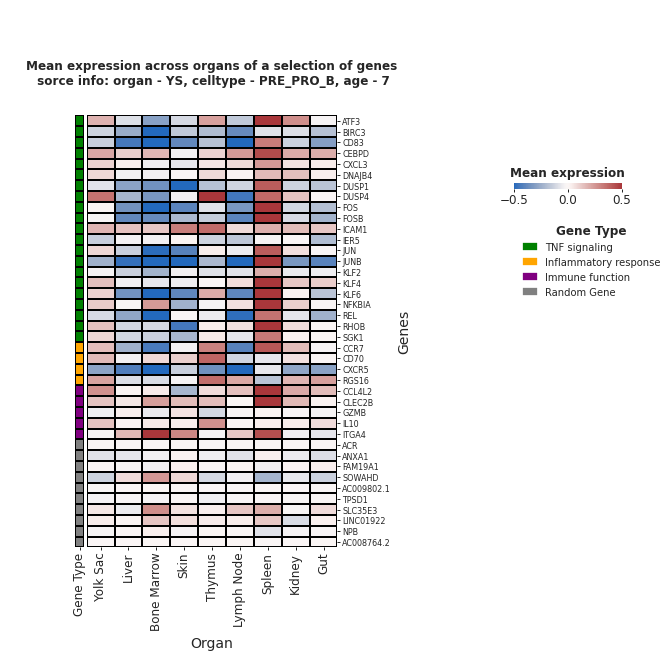

In [48]:
# plot heatmap of YS to other organs
SOURCE_ORGAN = "YS"
SOURCE_CELLTYPE = "PRE_PRO_B"
SOURCE_AGE = 7
adata_source, adata_preds = get_adata_preds(source_organ=SOURCE_ORGAN, source_celltype=SOURCE_CELLTYPE, source_age=SOURCE_AGE)
genes_in_list = [gene for gene in genes_fig3b if gene in adata_source.var_names]
source = {"organ": SOURCE_ORGAN, "celltype": SOURCE_CELLTYPE, "age": SOURCE_AGE}

targets = []
for oragn in ["LI", "BM", "SK", "TH", "MLN", "SP", "KI", "GU"]:
    targets.append({"organ": oragn, "celltype": SOURCE_CELLTYPE, "age": SOURCE_AGE})

df_heatmap = plot_heatmap(source, targets, genes_in_list, "Mean expression across organs of a selection of genes")

size of adata_source = (292, 4204)
INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        


0it [00:00, ?it/s]

INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        


/cs/labs/mornitzan/bar246802/SandBox2023/bioLordVenv/lib/python3.9/site-packages/scvi/data/_utils.py:175: UserWarning: Category 6 in adata.obs['_scvi_celltype'] has fewer than 3 cells. Models may not train properly.
  warnings.warn(
1it [00:00,  2.23it/s]

INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        
INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        
INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        


4it [00:00,  6.57it/s]

INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        
INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        


/cs/labs/mornitzan/bar246802/SandBox2023/bioLordVenv/lib/python3.9/site-packages/scvi/data/_utils.py:175: UserWarning: Category 6 in adata.obs['_scvi_celltype'] has fewer than 3 cells. Models may not train properly.
  warnings.warn(
/cs/labs/mornitzan/bar246802/SandBox2023/bioLordVenv/lib/python3.9/site-packages/scvi/data/_utils.py:175: UserWarning: Category 6 in adata.obs['_scvi_celltype'] has fewer than 3 cells. Models may not train properly.
  warnings.warn(


INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        


7it [00:01,  6.53it/s]

INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        
INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        


9it [00:01,  7.48it/s]


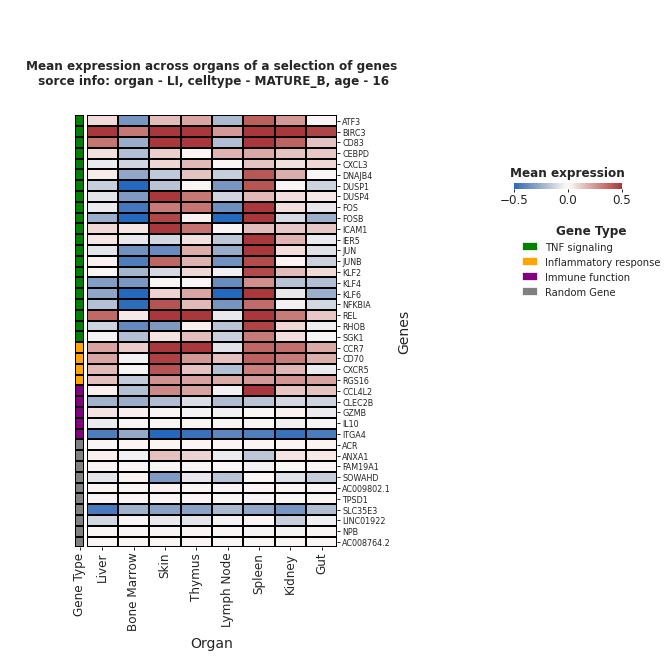

In [49]:
# plot heatmap of Liver to other organs
SOURCE_ORGAN = "LI"
SOURCE_CELLTYPE = "MATURE_B"
SOURCE_AGE = 16
adata_source, adata_preds = get_adata_preds(source_organ=SOURCE_ORGAN, source_celltype=SOURCE_CELLTYPE, source_age=SOURCE_AGE)
genes_in_list = [gene for gene in genes_fig3b if gene in adata_source.var_names]
source = {"organ": SOURCE_ORGAN, "celltype": SOURCE_CELLTYPE, "age": SOURCE_AGE}
targets = []

for oragn in ["BM", "SK", "TH", "MLN", "SP", "KI", "GU"]:
    targets.append({"organ": oragn, "celltype": SOURCE_CELLTYPE, "age": SOURCE_AGE})

df_heatmap = plot_heatmap(source, targets, genes_in_list, "Mean expression across organs of a selection of genes")

size of adata_source = (23, 4204)
INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        


0it [00:00, ?it/s]

INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        


/cs/labs/mornitzan/bar246802/SandBox2023/bioLordVenv/lib/python3.9/site-packages/scvi/data/_utils.py:175: UserWarning: Category 6 in adata.obs['_scvi_celltype'] has fewer than 3 cells. Models may not train properly.
  warnings.warn(
1it [00:00,  2.33it/s]

INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        
INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        
INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        


4it [00:00,  6.87it/s]

INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        
INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        


/cs/labs/mornitzan/bar246802/SandBox2023/bioLordVenv/lib/python3.9/site-packages/scvi/data/_utils.py:175: UserWarning: Category 6 in adata.obs['_scvi_celltype'] has fewer than 3 cells. Models may not train properly.
  warnings.warn(
/cs/labs/mornitzan/bar246802/SandBox2023/bioLordVenv/lib/python3.9/site-packages/scvi/data/_utils.py:175: UserWarning: Category 6 in adata.obs['_scvi_celltype'] has fewer than 3 cells. Models may not train properly.
  warnings.warn(


INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        


7it [00:01,  6.66it/s]

INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        
INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        


9it [00:01,  7.66it/s]


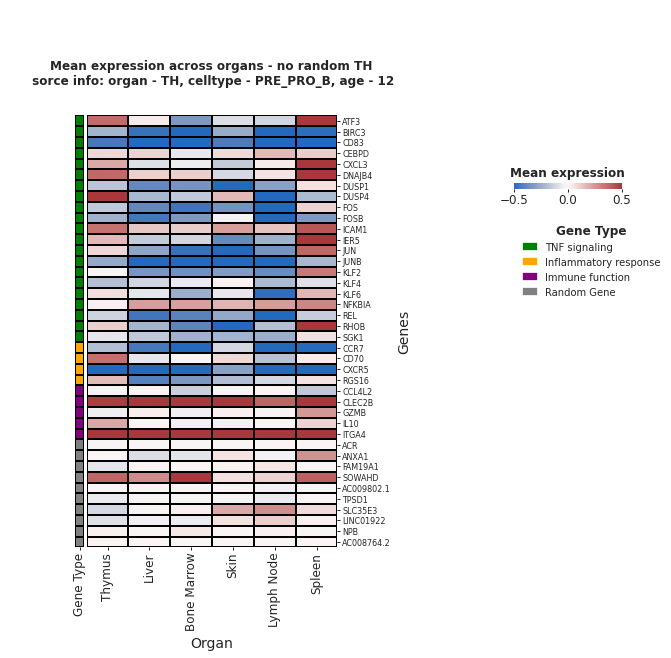

In [50]:
# plot heatmap of Thymus to other organs
SOURCE_ORGAN = "TH"
SOURCE_CELLTYPE = "PRE_PRO_B"
SOURCE_AGE = 12
adata_source, adata_preds = get_adata_preds(source_organ=SOURCE_ORGAN, source_celltype=SOURCE_CELLTYPE, source_age=SOURCE_AGE)
genes_in_list = [gene for gene in genes_fig3b if gene in adata_source.var_names]
source = {"organ": SOURCE_ORGAN, "celltype": SOURCE_CELLTYPE, "age": SOURCE_AGE}
targets = []
for oragn in ["LI", "BM", "SK", "MLN", "SP"]:
    targets.append({"organ": oragn, "celltype": SOURCE_CELLTYPE, "age": SOURCE_AGE})
df_heatmap = plot_heatmap(source, targets, genes_in_list, f"Mean expression across organs - no random {SOURCE_ORGAN}")
df_heatmap.to_csv(SAVE_DIR + f"df_heatmap_{SOURCE_ORGAN}.csv", index=False)

size of adata_source = (40, 4204)
INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        


0it [00:00, ?it/s]

INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        


/cs/labs/mornitzan/bar246802/SandBox2023/bioLordVenv/lib/python3.9/site-packages/scvi/data/_utils.py:175: UserWarning: Category 6 in adata.obs['_scvi_celltype'] has fewer than 3 cells. Models may not train properly.
  warnings.warn(
1it [00:00,  2.34it/s]

INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        
INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        
INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        


4it [00:00,  6.84it/s]

INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        
INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        


/cs/labs/mornitzan/bar246802/SandBox2023/bioLordVenv/lib/python3.9/site-packages/scvi/data/_utils.py:175: UserWarning: Category 6 in adata.obs['_scvi_celltype'] has fewer than 3 cells. Models may not train properly.
  warnings.warn(
/cs/labs/mornitzan/bar246802/SandBox2023/bioLordVenv/lib/python3.9/site-packages/scvi/data/_utils.py:175: UserWarning: Category 6 in adata.obs['_scvi_celltype'] has fewer than 3 cells. Models may not train properly.
  warnings.warn(


INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        


7it [00:01,  6.63it/s]

INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        
INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        


9it [00:01,  7.66it/s]


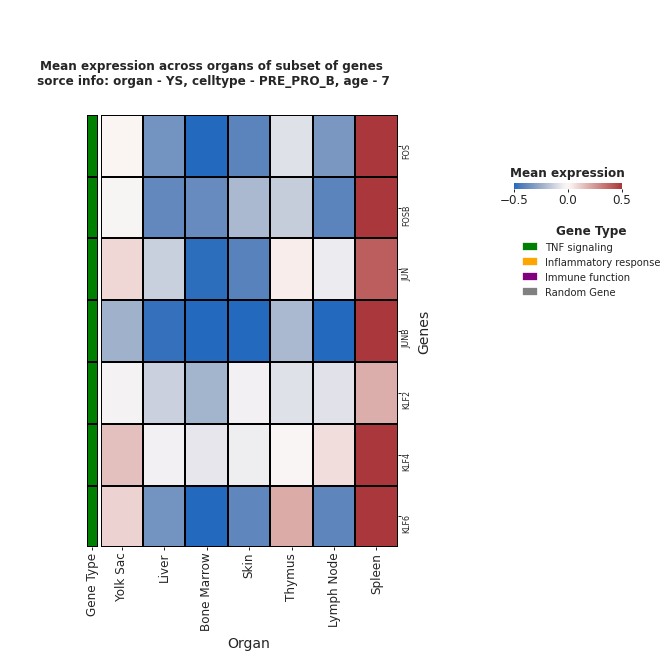

In [51]:
# Create a sub-heatmap focusing on a subset of genes from the previous list
subset_genes = [
    "FOS",
    "FOSB",
    
    "JUN", # FROM https://www.nature.com/articles/s42003-023-04454-5
    "JUNB",
    
    "KLF2",
    "KLF4",
    "KLF6",
]

genes_colors = {}
for gene in subset_genes:
    if gene in genes_fig3b_tnf:
        genes_colors[gene] = "green"
    elif gene in genes_fig3b_inflam:
        genes_colors[gene] = "orange"
    elif gene in genes_fig3b_immune_func:
        genes_colors[gene] = "purple"
        

# plot heatmap
SOURCE_ORGAN = "YS"
SOURCE_CELLTYPE = "PRE_PRO_B"
SOURCE_AGE = 7
adata_source, adata_preds = get_adata_preds(source_organ=SOURCE_ORGAN, source_celltype=SOURCE_CELLTYPE, source_age=SOURCE_AGE)
genes_in_list = [gene for gene in subset_genes if gene in adata_source.var_names]
source = {"organ": SOURCE_ORGAN, "celltype": SOURCE_CELLTYPE, "age": SOURCE_AGE}
targets = []
for oragn in ["LI", "BM", "SK", "TH", "MLN", "SP"]:
    targets.append({"organ": oragn, "celltype": SOURCE_CELLTYPE, "age": SOURCE_AGE})
filename_suffix = "_subset_heatmap.png"
df_heatmap = plot_heatmap(source, targets, genes_in_list, f"Mean expression across organs of subset of genes", filename_suffix)

## Load GSEA output
create dot plots using the results of the GSEA (which was generated using the R script: b_cells_GSEA.Rmd)

In [52]:
def format_pathways_names(file_prefix, df_gsea=None):
    pathways = None
    if file_prefix == "go_dots_ys_to_sp_2":
        pathways = [
            "Immunoglobulin production",
            "Production of molecular mediator of immune response",
            "T cell proliferation", "Regulation of T cell proliferation",
            "Adaptive immune response", "B cell mediated immunity",
            "Regulation of mononuclear cell proliferation",
            "Immunoglobulin mediated immune response",
            "Regulation of lymphocyte proliferation",
            "Mononuclear cell proliferation",
            "Regulation of biosynthetic process",
            "Macromolecule biosynthetic process",
            "Regulation of macromolecule biosynthetic process",
            "Regulation of cellular biosynthetic process",
            "Cellular nitrogen compound biosynthetic process",
            "Biosynthetic process",
            "Cellular nitrogen compound metabolic process",
            "Regulation of nitrogen compound metabolic process",
            "Regulation of cellular metabolic process",
            "Regulation of macromolecule metabolic process"
        ]
    elif file_prefix == "ys_to_li":
        pathways = [
            "Tnfa signaling via NF-" + r"$\kappa$" + "B (H)", "Hypoxia (H)",
            "Apoptosis (H)", "Il2-STAT5 signaling (H)",
            'Epithelial \nmesenchymal transition (H)', 'Uv response up (H)',
            'Kras signaling up (H)', 'Inflammatory response (H)'
        ]

    if pathways is not None:
        df_gsea["Pathways"] = pathways
    else:
        df_gsea['Pathways'] = df_gsea['Pathways'].apply(
            lambda x: x.replace('HALLMARK_', '').replace("_", " ").replace(
                ' - Homo sapiens (human)', '').title().replace("Il-", "IL-").replace("Of", "of"))
        
        df_gsea['Pathways'] = df_gsea['Pathways'].apply(
            lambda x:  re.sub(r"Il(\d+)", r"IL\1", x))

    return df_gsea

In [53]:
def load_gsea(file_path):  
    df = pd.read_csv(file_path)
    df['Status'] = df['Unnamed: 0'].str.split('.').str[0]
    df = df.sort_values(by=["NES"], ascending=False)
    df["Pathways"] = df["Description"].astype(str).copy()    
    df_gsea = df
    df_gsea["$-log_{10}(p_{adj})$"] = np.round(-1 * np.log10(df_gsea["p.adjust"]), 1)
    df_gsea["Gene fraction"] = df_gsea["GeneRatio"]
    x_val = "NES"
    df_gsea = df_gsea.sort_values(by=[x_val], ascending=False)
    return df_gsea

In [54]:
def create_dots_plot(df_gsea=None, file_prefix="", title=""):
    nterms =  len(df_gsea) # get top 10 gene pathways
    # create dataframes of actived and suppressed gene pathways
    df_gsea = format_pathways_names(file_prefix=file_prefix, df_gsea=df_gsea)
    df_gsea_activated = df_gsea[df_gsea['Status'].str.contains('activated', case=False)]
    df_gsea_suppressed = df_gsea[df_gsea['Status'].str.contains('suppressed', case=False)]
    # create the dot plot
    fig_hight = 8
    fig_width = 6.5
    fig, axs = plt.subplots(figsize=(fig_width, fig_hight))
    sns.set_theme(style="white")
    plt.rcParams["xtick.bottom"] = True
    plt.rcParams["ytick.left"] = True
    x_val = "NES"
    sns.cubehelix_palette(
        n_colors=nterms,
        start=0.5,
        rot=-0.75,
        dark=0.4,
    )
    
    df_gsea["GenFractionSize"] = None
    for n, frac in enumerate(df_gsea["Gene fraction"]):
        df_gsea.loc[df_gsea['Gene fraction'] == frac, 'GenFractionSize'] = 50 + 100**n
    
    size = len(set(df_gsea['$-log_{10}(p_{adj})$']))
    sns.scatterplot(
        data=df_gsea,
        x=x_val,
        y="Pathways",
        size="Gene fraction",
        hue="$-log_{10}(p_{adj})$",
        palette=sns.cubehelix_palette(
            n_colors=size,
            start=1.5,
        ),
        ax=axs,
    )
    sns.despine(offset=0, trim=False)
    # set additional settings
    plt.legend().remove()
    plt.legend(
        bbox_to_anchor=(1.6, 1),
        loc="upper left",
        borderaxespad=0.2,
        frameon=False,
        ncol=1,
        fontsize=14,
    )
    plt.yticks(fontsize=16)
    plt.xticks(fontsize=16)
    plt.ylabel("")
    plt.xlabel("Normalized Enrichment Score", fontsize=16)
    plt.title(f"{title} GSEA - activated and suppressed pathways", fontsize=20)
    
    # Set y-axis tick labels and colors based on 'Color' column
    for tick_label, status in zip(axs.get_yticklabels(), df_gsea['Status']):
        color = "#8a2b3e"
        if status == "activated":
            color = "#29752e"
        tick_label.set_color(color)

    # save the plot, notice the creating of the GSEA folder is done offline when running the R script
    plt.savefig(
        FIG_DIR + "GSEA/" + file_prefix + ".png",
        dpi=300,
        bbox_inches="tight",
        transparent=True,
    )
    plt.show()

    return df_gsea

In [55]:
def dplots(file_prefix, title_sufix):
    file_path = SAVE_DIR + "GSEA/" + file_prefix + "/" + file_prefix
    
    df_gsea_hallmark = load_gsea(file_path + "_hallmark.csv")
    df_gsea_kegg = load_gsea(file_path + "_kegg.csv")
    df_gsea_go = load_gsea(file_path + "_go.csv")
    
    # dot ploe of Hallmark GSEA
    title = f"{title_sufix} - hallmark"
    save_file_prefix = "hallmark_dots_" + file_prefix
    create_dots_plot(df_gsea=df_gsea_hallmark, file_prefix=save_file_prefix, title=title)
    
    # dot ploe of KEGG GSEA
    title = f"{title_sufix} - kegg"
    save_file_prefix = "kegg_dots_" + file_prefix
    create_dots_plot(df_gsea=df_gsea_kegg, file_prefix=save_file_prefix, title=title)
    
    # dot ploe of GO GSEA
    title = f"{title_sufix} - GO"
    save_file_prefix = "go_dots_" + file_prefix
    return create_dots_plot(df_gsea=df_gsea_go, file_prefix=save_file_prefix, title=title)

## GSEA of Yolk sac to Spleen

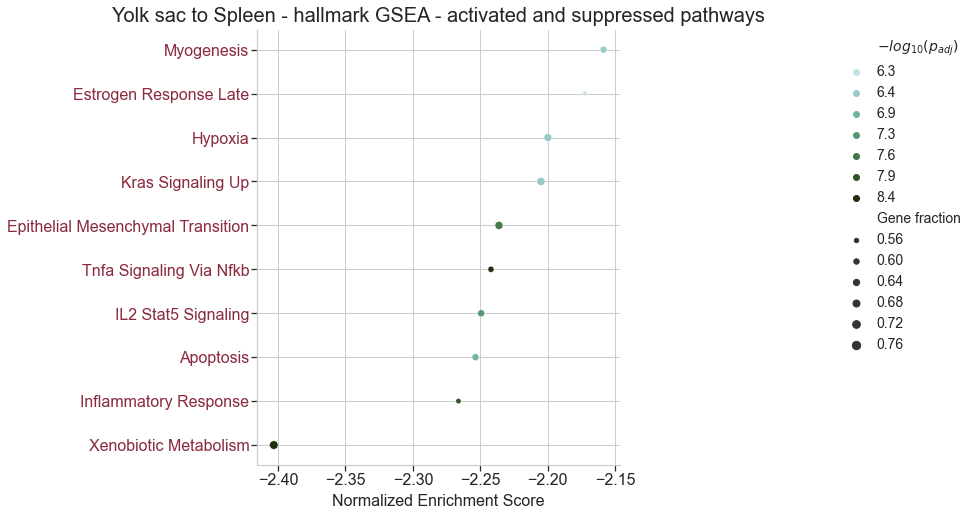

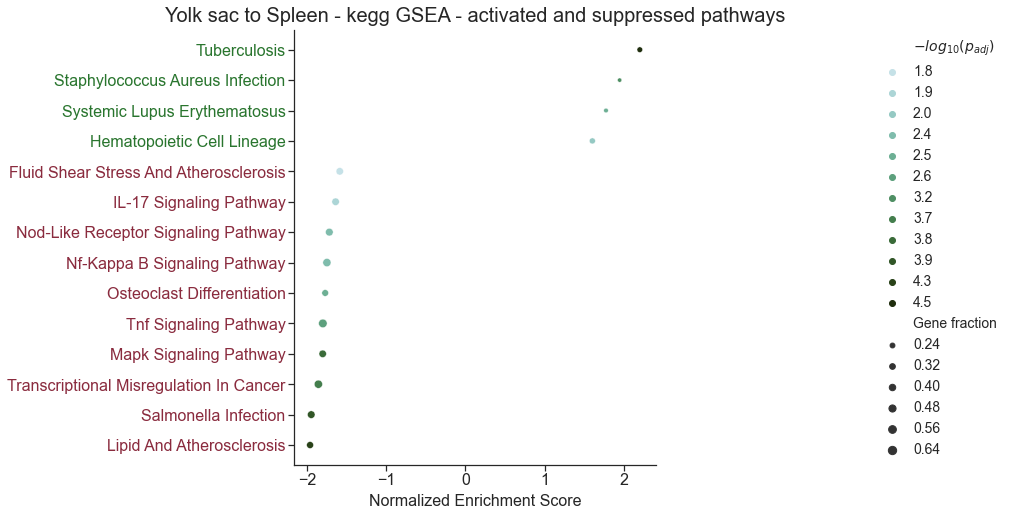

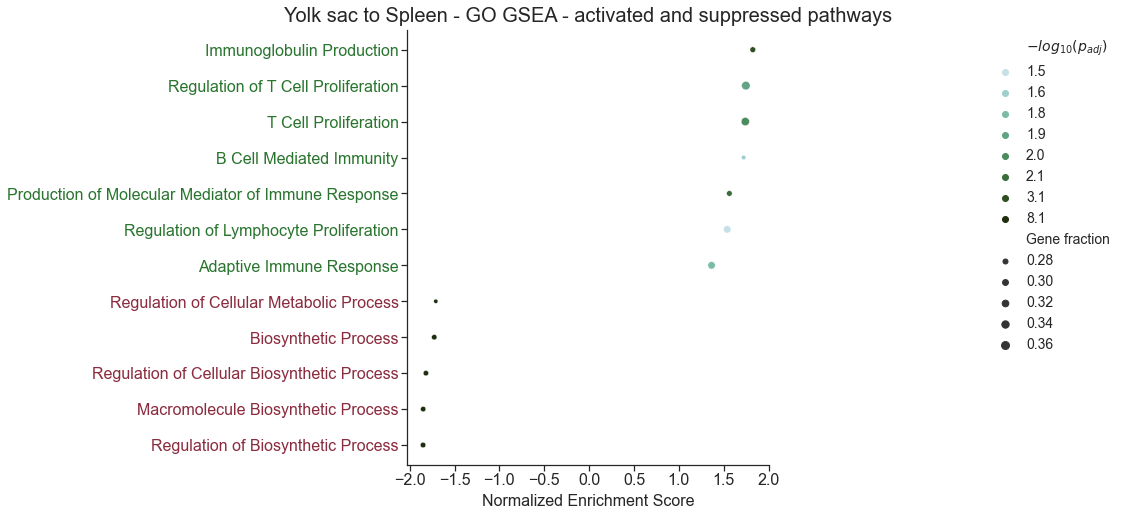

In [56]:
df = dplots(file_prefix = "ys_to_sp", title_sufix="Yolk sac to Spleen")

## GSEA of Yolk sac to Liver

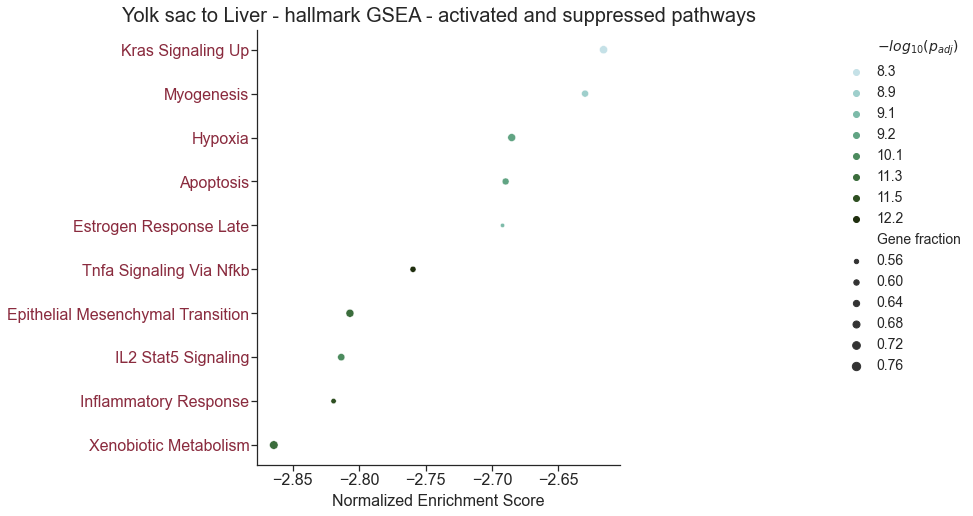

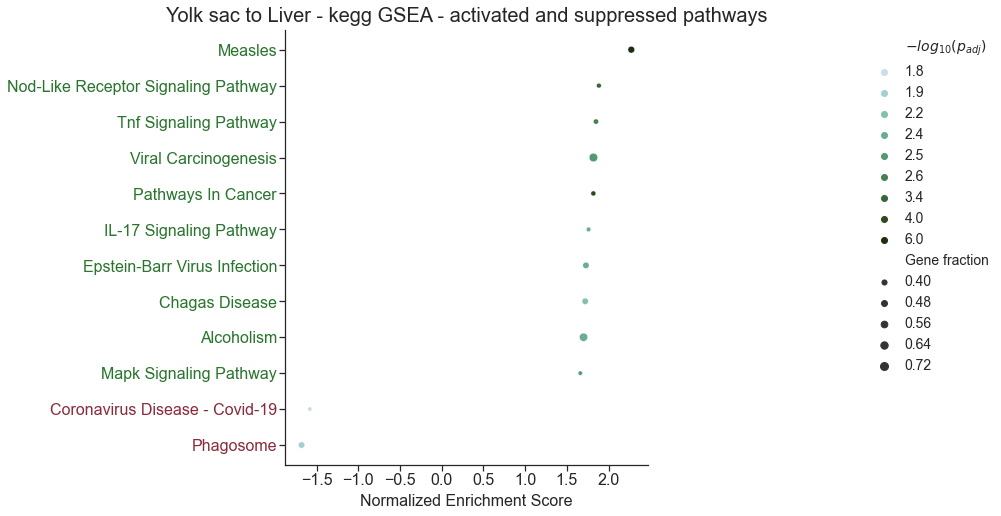

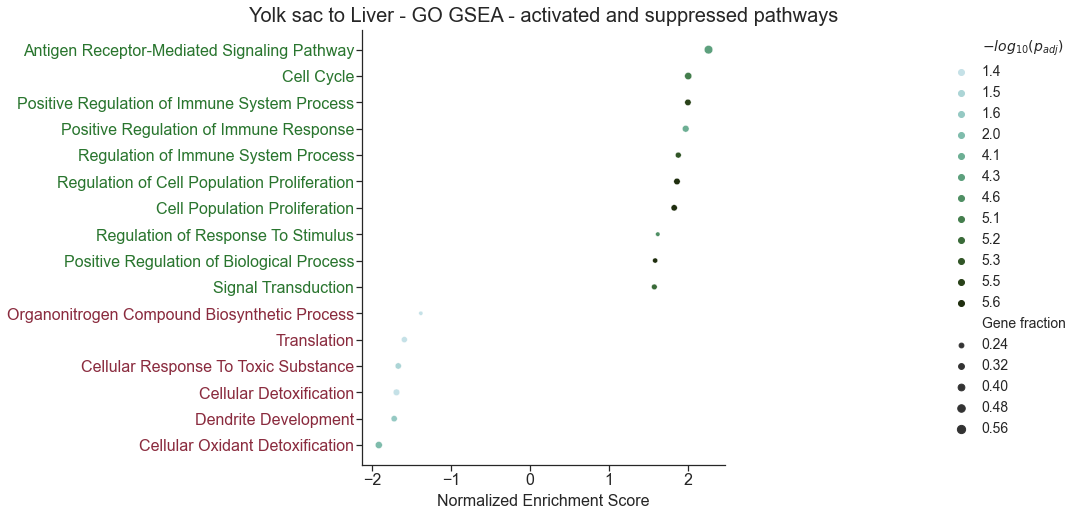

In [57]:
df = dplots(file_prefix = "ys_to_li", title_sufix="Yolk sac to Liver")

## GSEA of Yolk sac to Skin

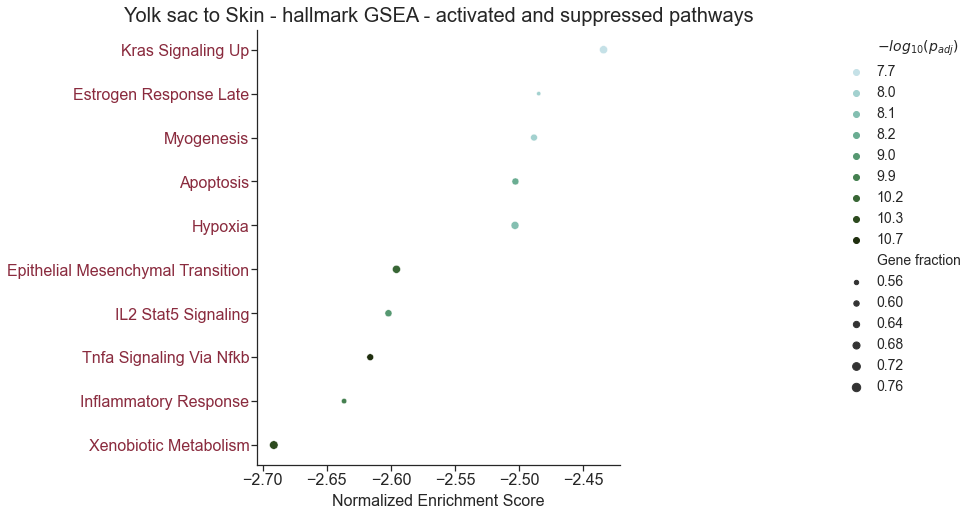

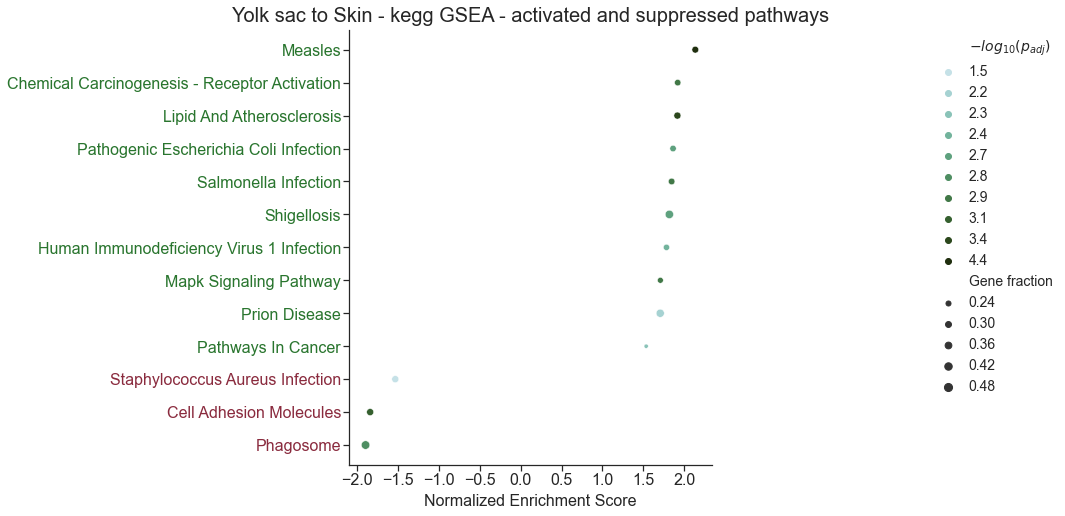

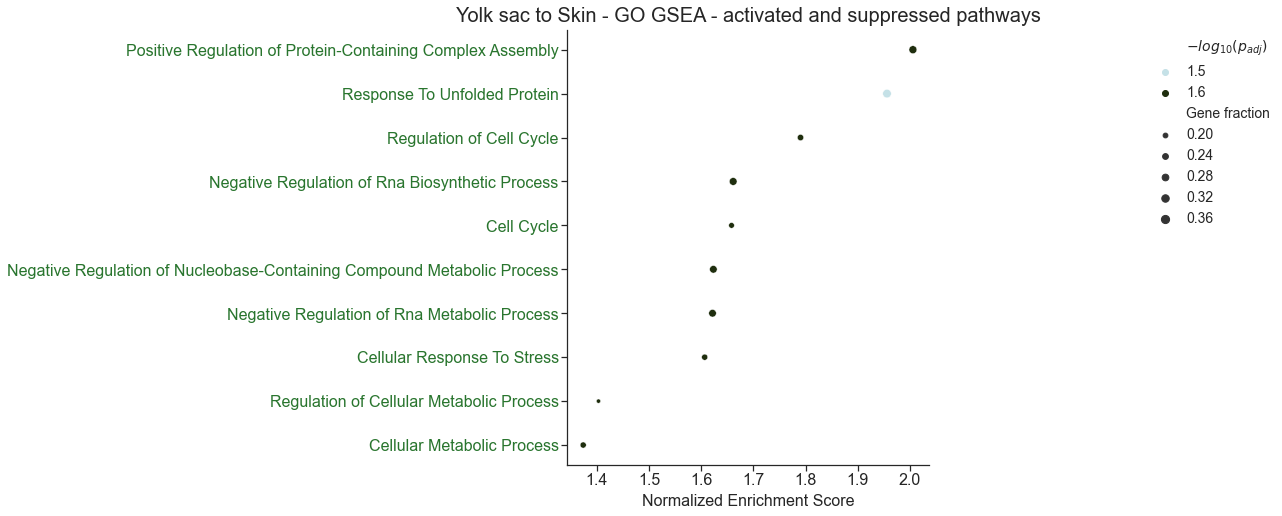

In [58]:
df = dplots(file_prefix = "ys_to_sk", title_sufix="Yolk sac to Skin")

## Liver

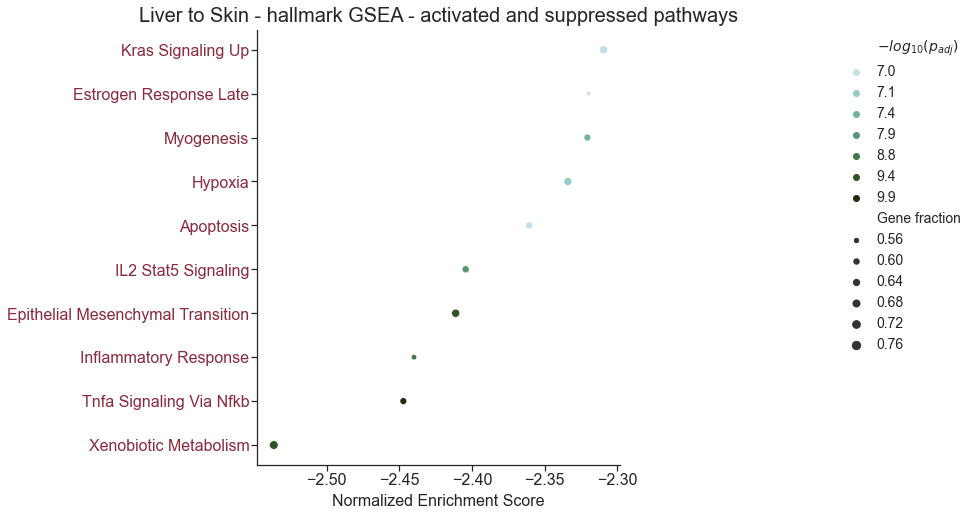

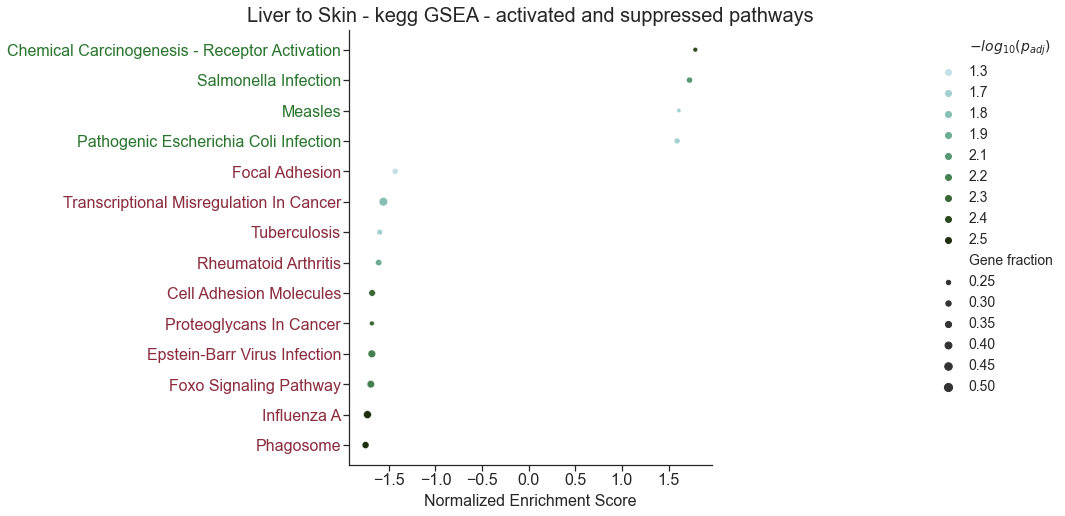

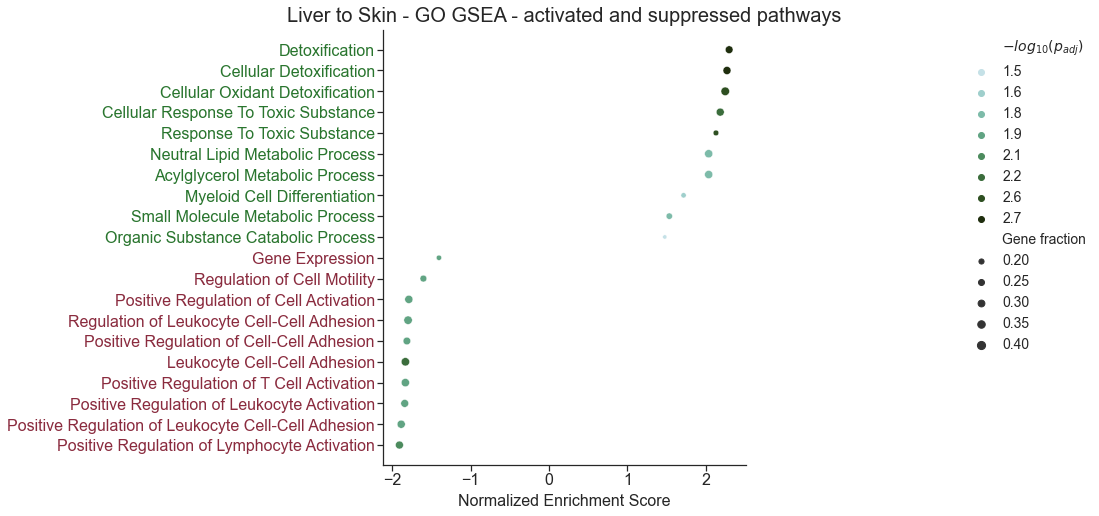

In [59]:
df = dplots(file_prefix = "li_to_sk", title_sufix="Liver to Skin")

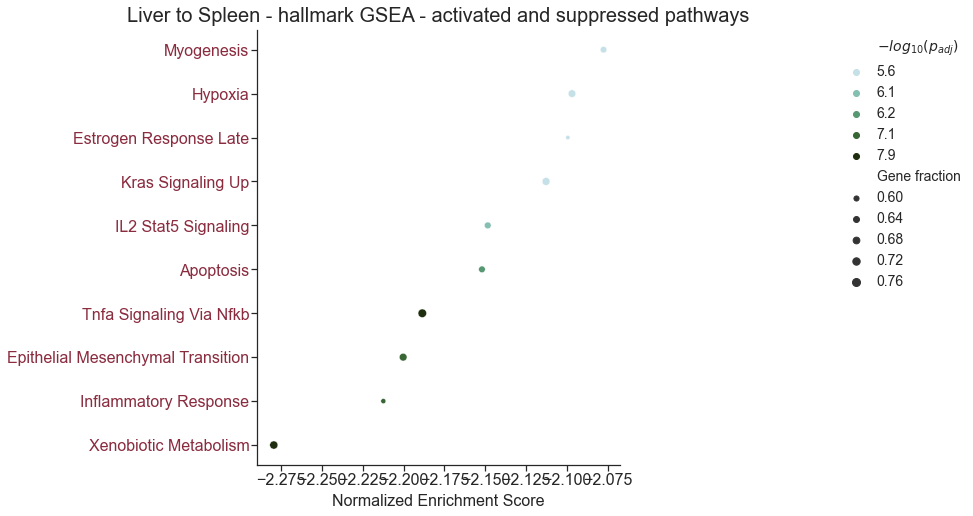

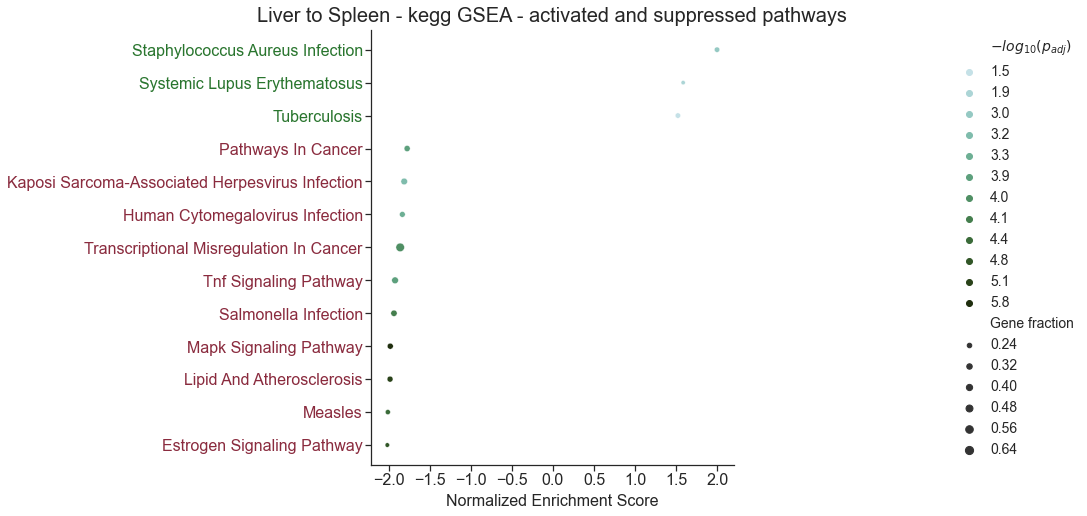

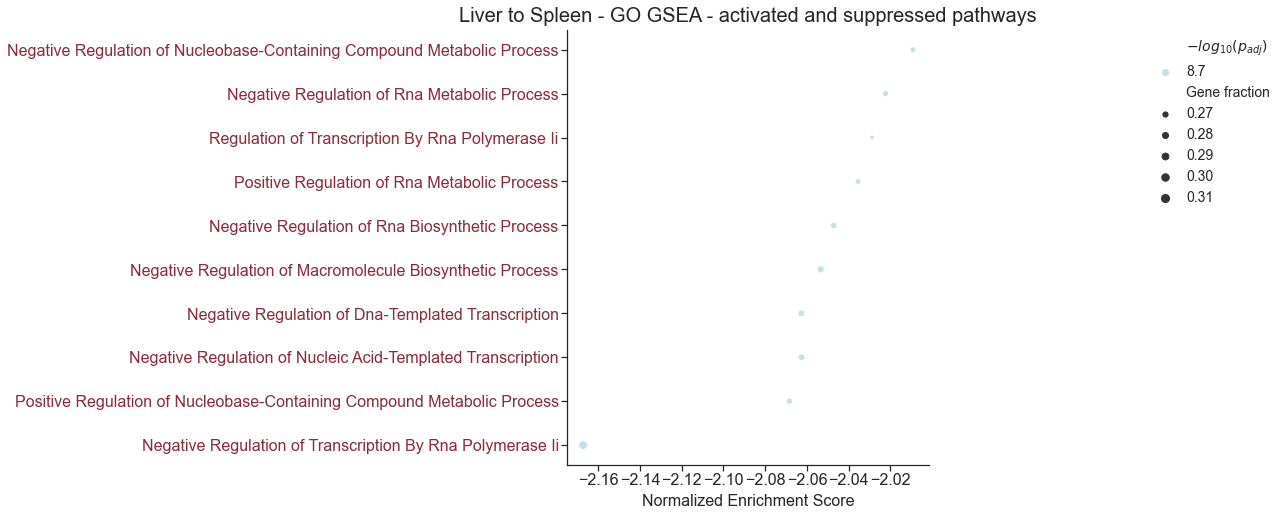

In [60]:
df = dplots(file_prefix = "li_to_sp", title_sufix="Liver to Spleen")

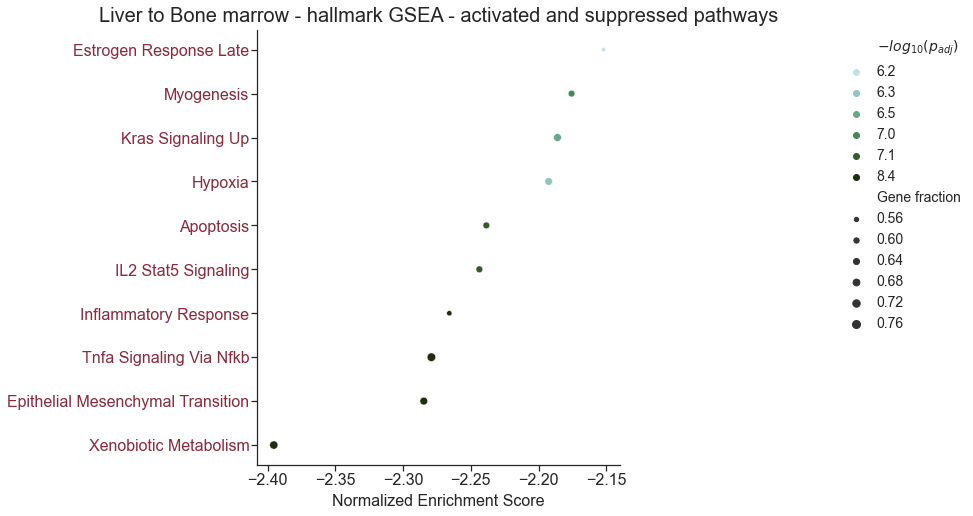

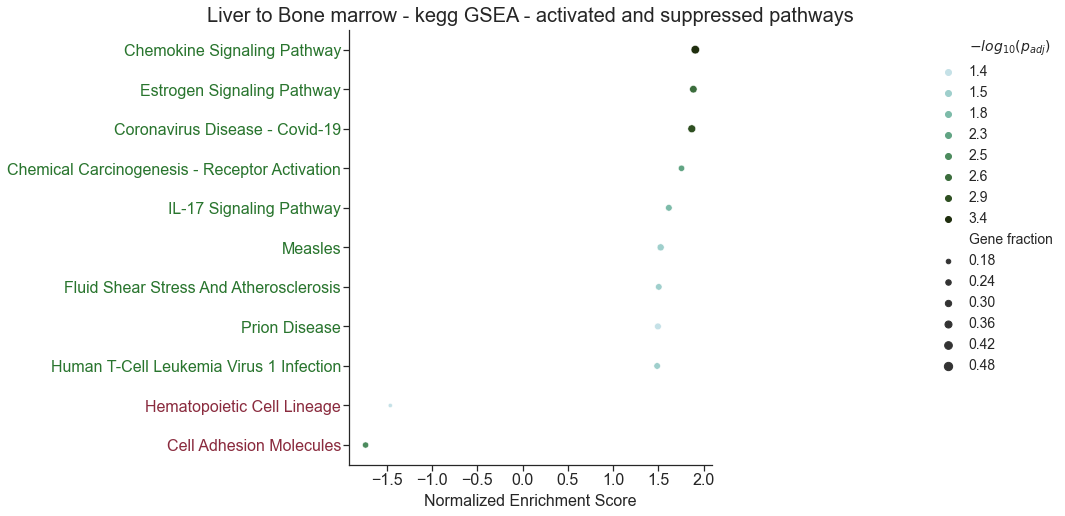

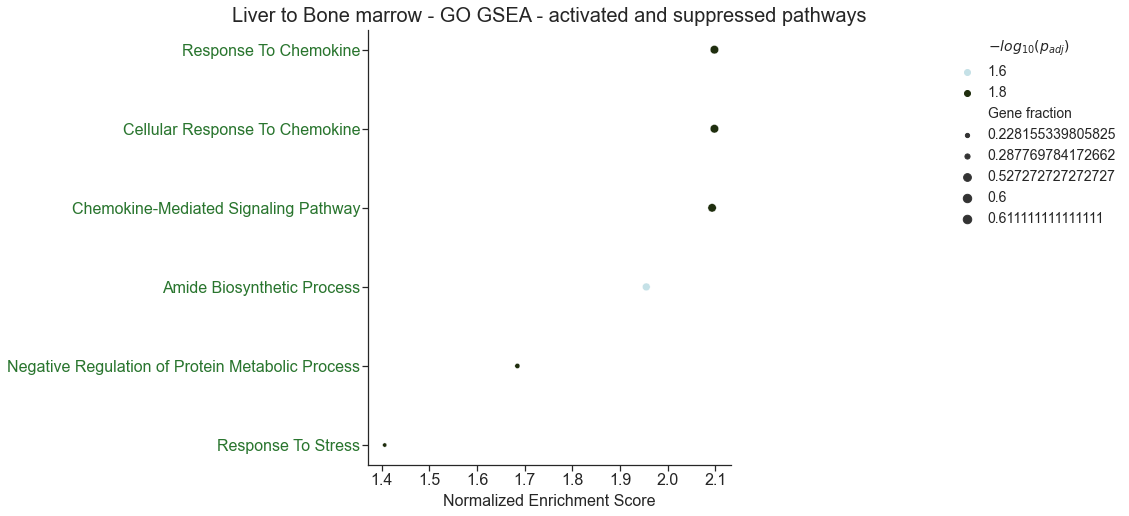

In [61]:
df = dplots(file_prefix = "li_to_bm", title_sufix="Liver to Bone marrow")

## Thymus

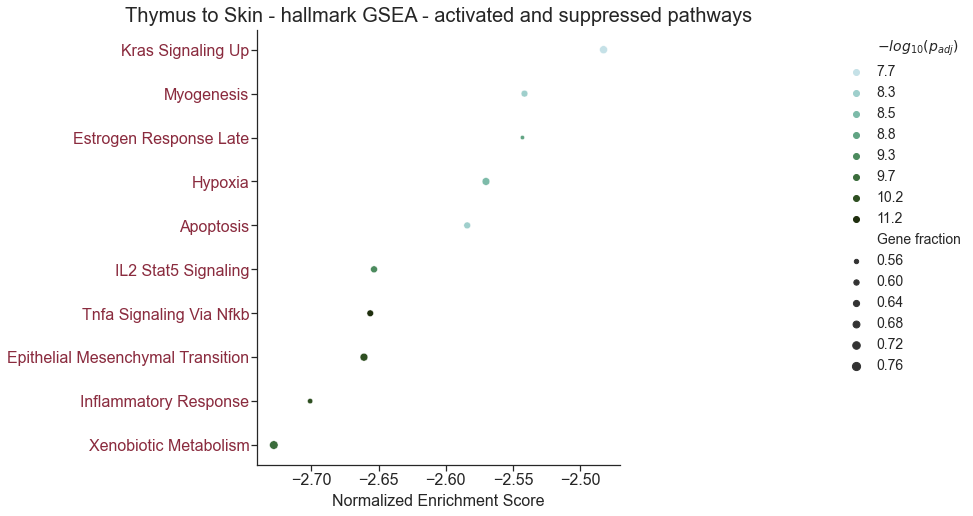

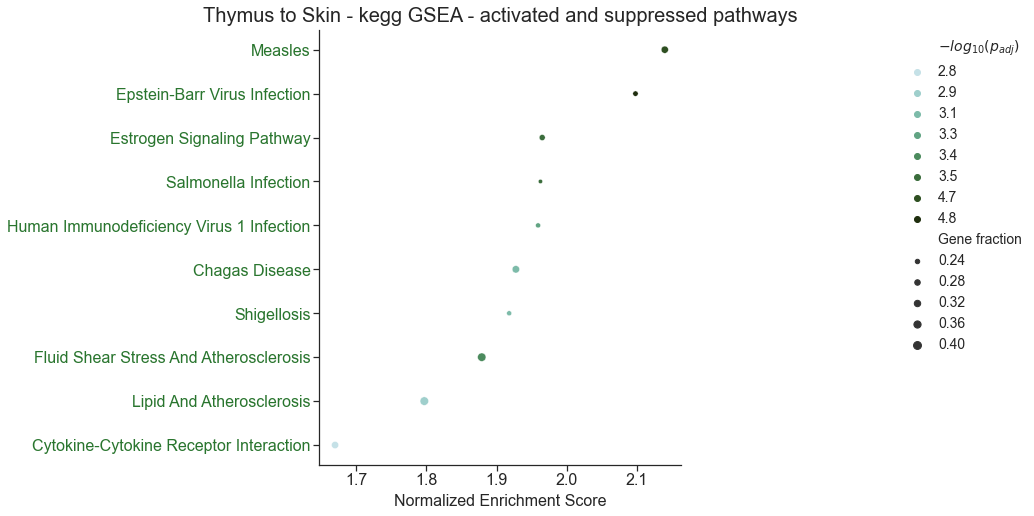

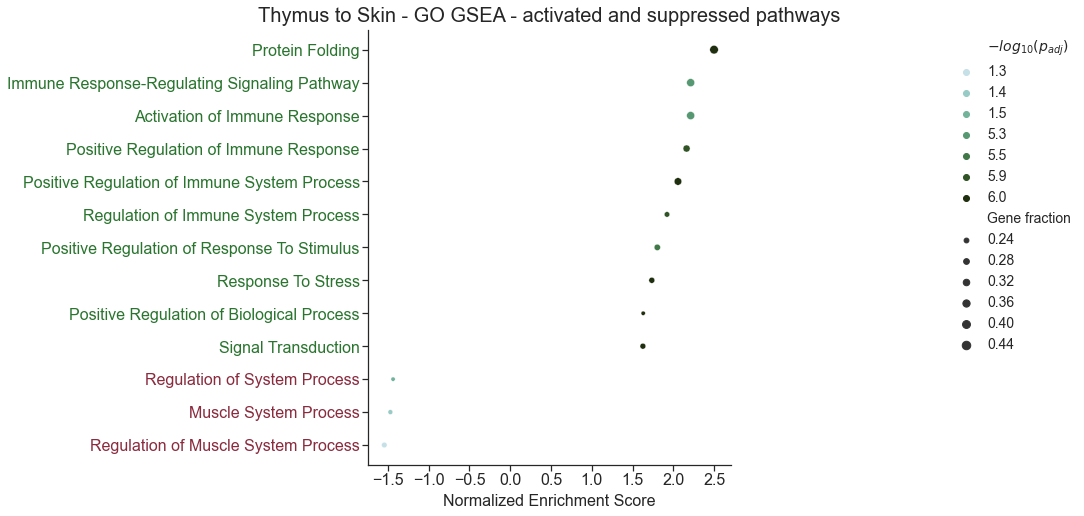

In [62]:
df = dplots(file_prefix = "th_to_sk", title_sufix="Thymus to Skin")

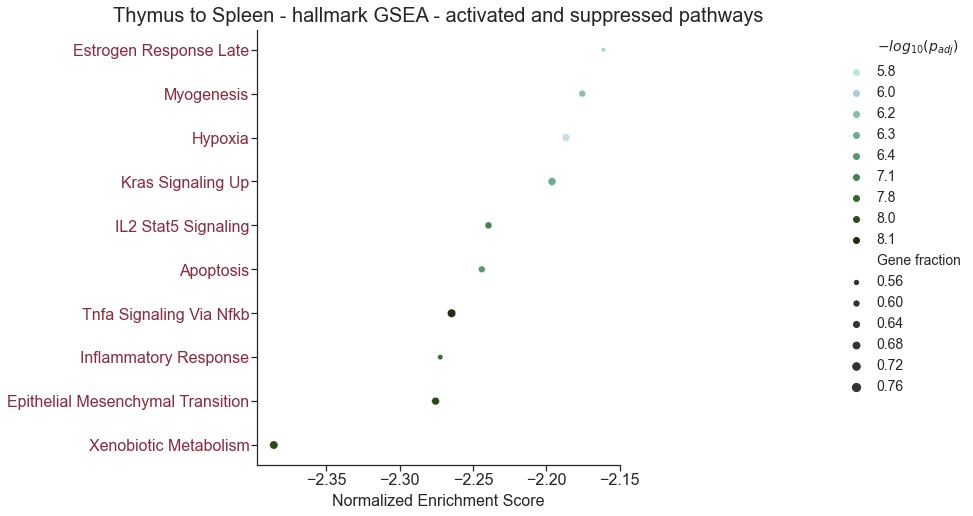

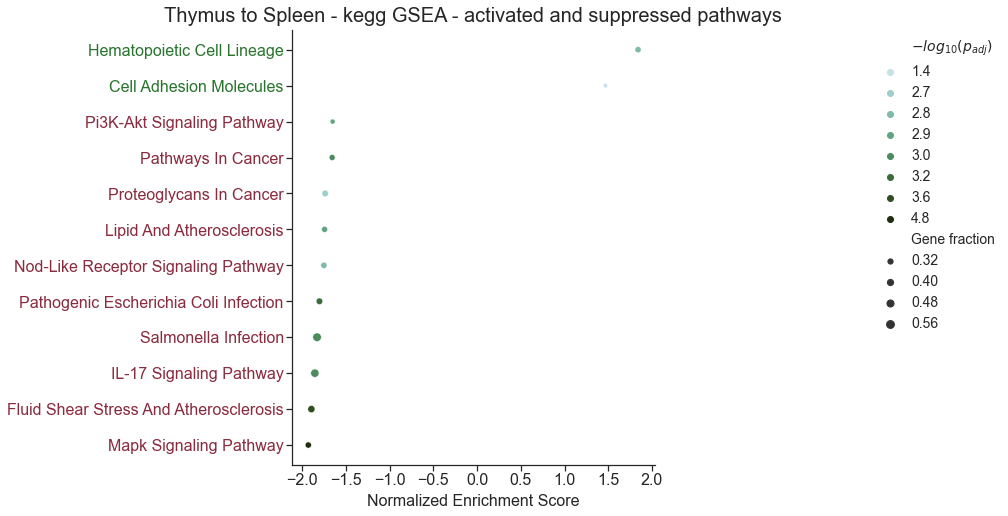

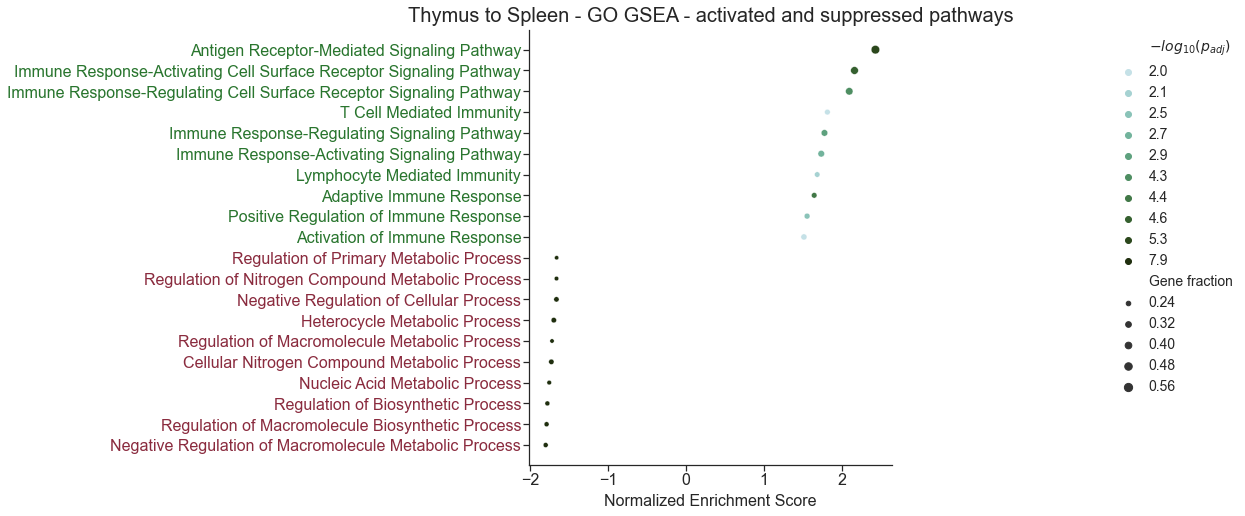

In [63]:
df = dplots(file_prefix = "th_to_sp", title_sufix="Thymus to Spleen")

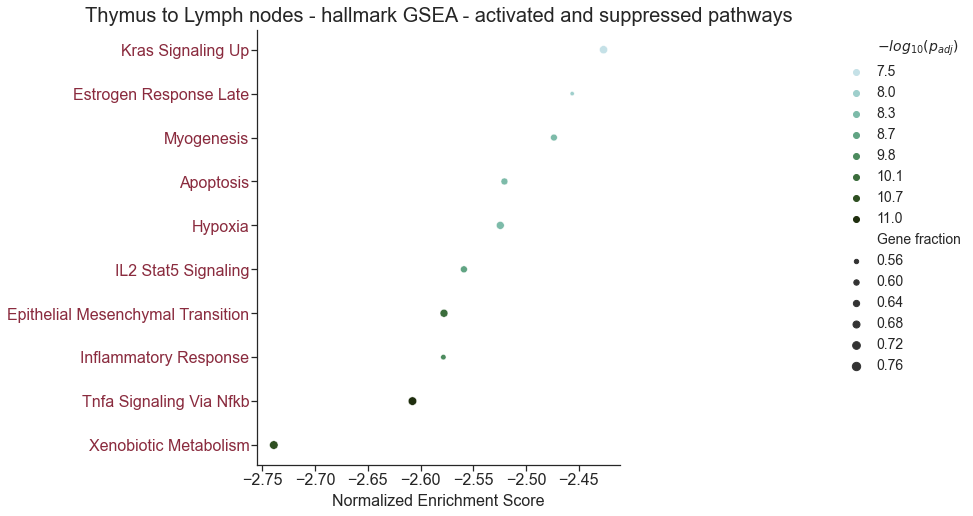

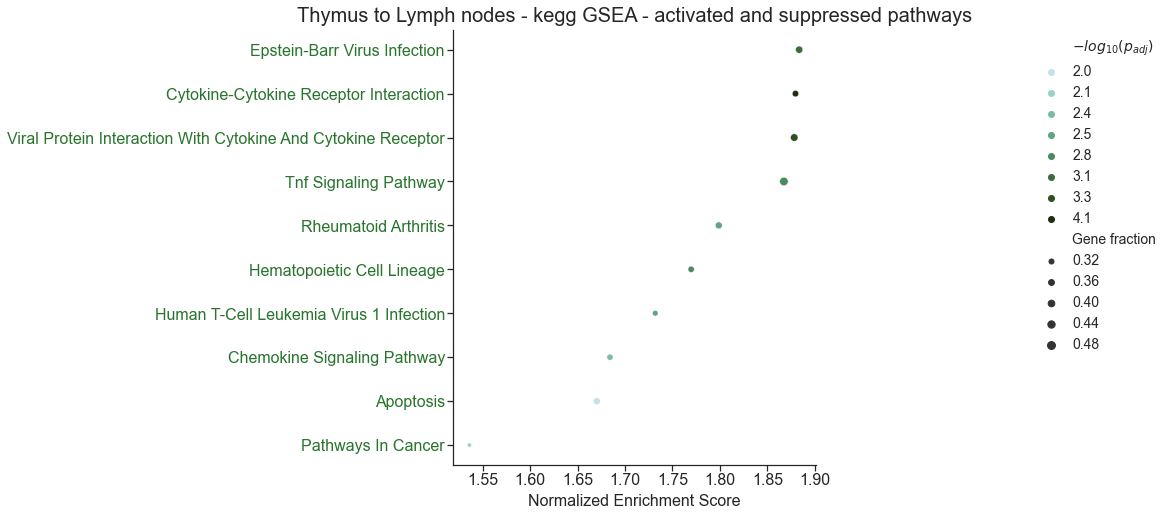

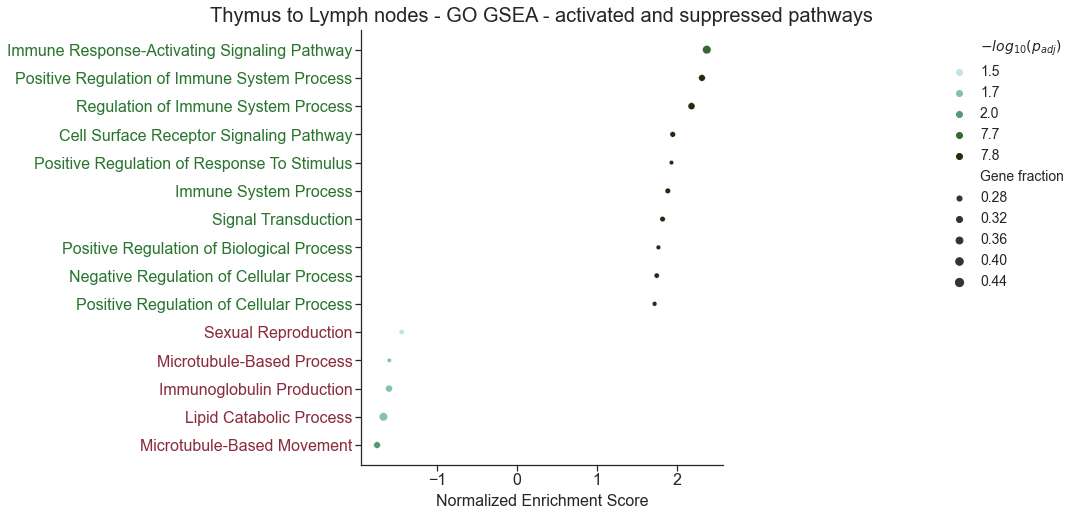

In [64]:
df = dplots(file_prefix = "th_to_mln", title_sufix="Thymus to Lymph nodes")

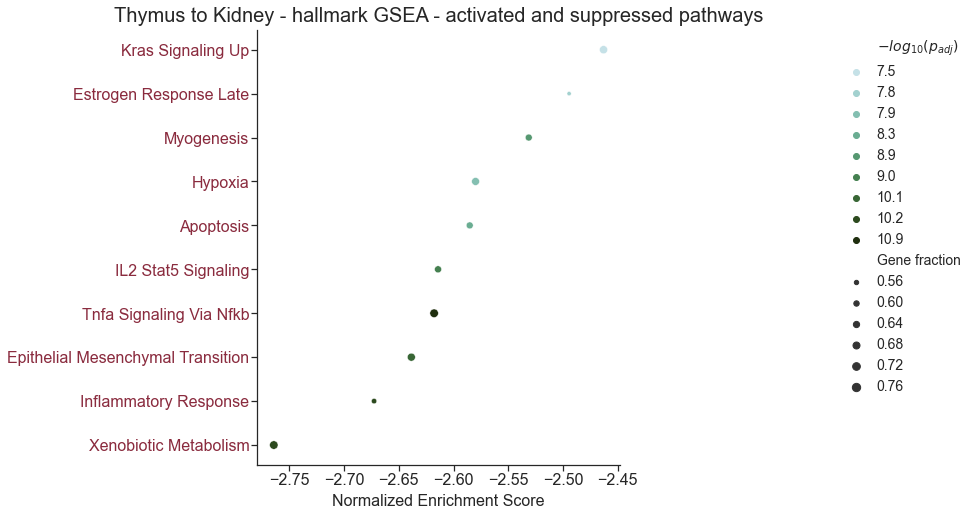

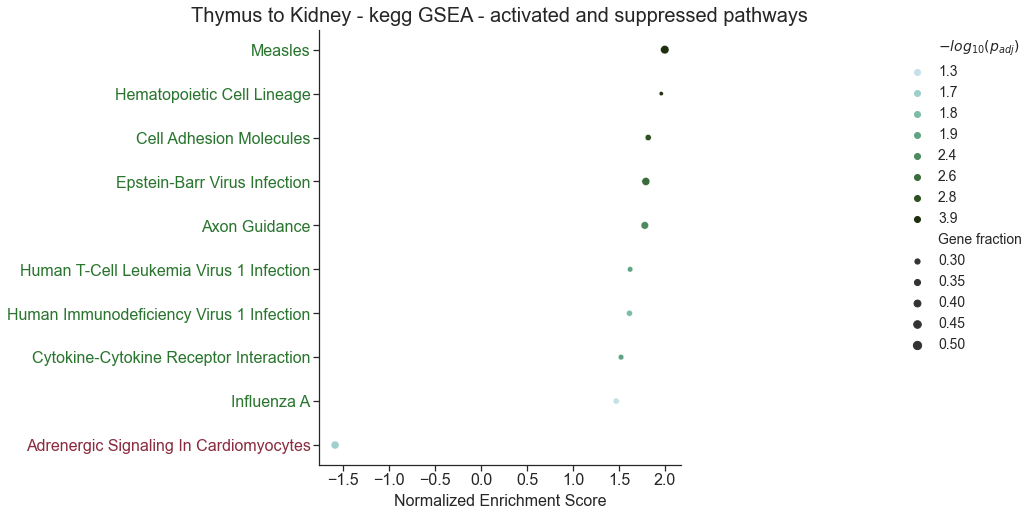

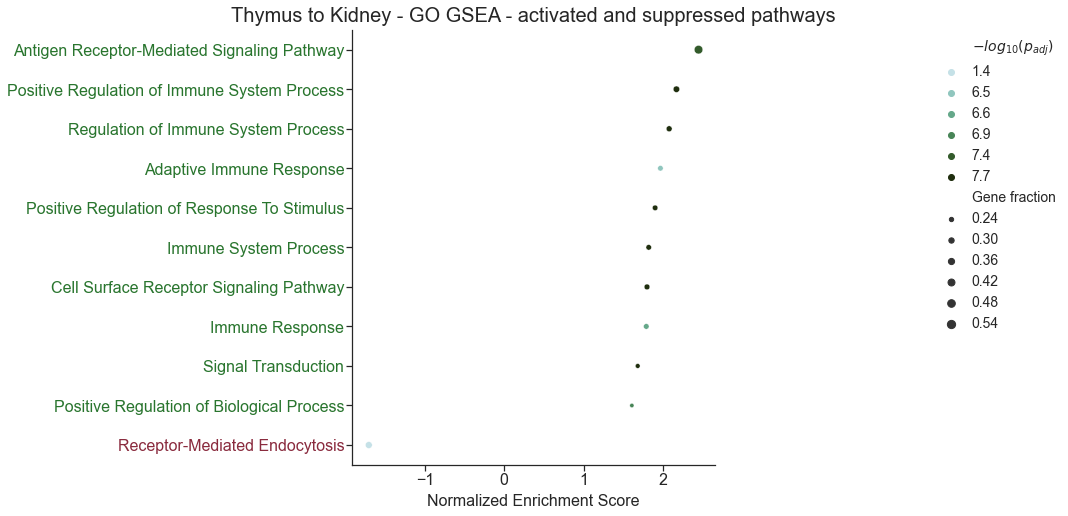

In [65]:
df = dplots(file_prefix = "th_to_ki", title_sufix="Thymus to Kidney")

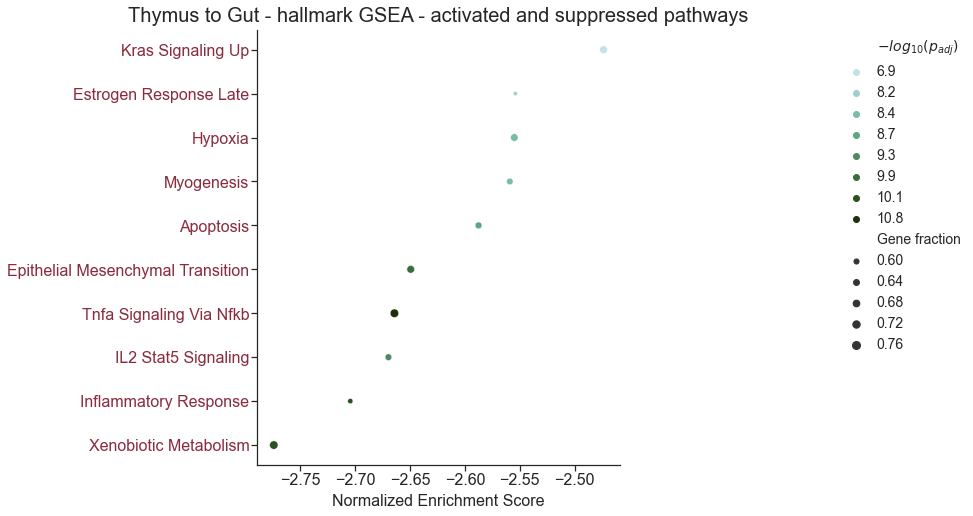

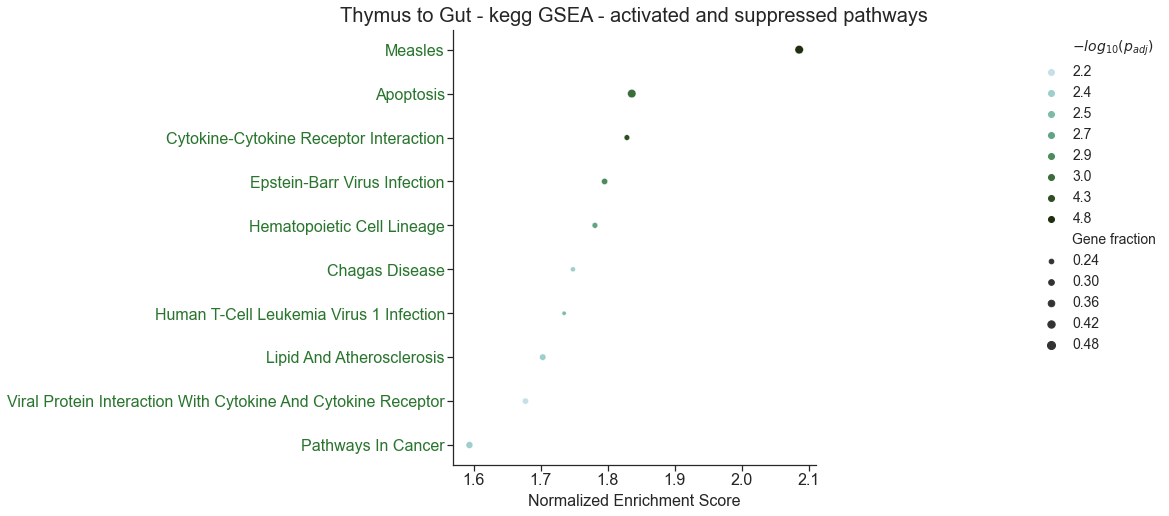

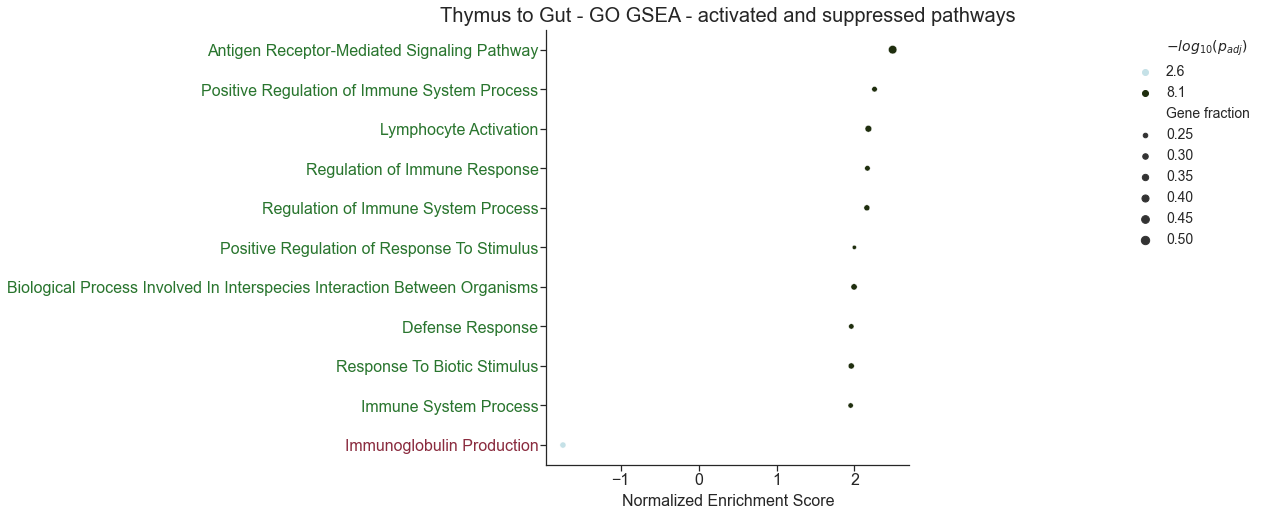

In [66]:
df = dplots(file_prefix = "th_to_gu", title_sufix="Thymus to Gut")